<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/Crime_Hotspot_Prediction_LSTM_Area_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [3]:
#Import dataset:

crime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crime_clean.csv')
print(crime_df.shape)

(2883802, 26)


In [4]:
crime_df.columns

Index(['DR_NO', 'Date_Rptd', 'DATE_OCC', 'TIME_OCC', 'AREA', 'AREA_NAME',
       'Rpt_Dist_No', 'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age',
       'Vict_Sex', 'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp',
       'Avg_Dewpoint', 'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure',
       'Total_Precipitation', 'Weapon_Reported', 'Crime_Category',
       'Crime_Category_Code', 'Region_Ethnic_Origin'],
      dtype='object')

In [5]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [6]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])

In [7]:
crime_df.set_index('DATE_OCC', inplace=True)


In [8]:
# Convert the following into categorical

crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [9]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [10]:
print(crime_df.columns)

Index(['DR_NO', 'Date_Rptd', 'TIME_OCC', 'AREA', 'AREA_NAME', 'Rpt_Dist_No',
       'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age', 'Vict_Sex',
       'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp', 'Avg_Dewpoint',
       'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure', 'Total_Precipitation',
       'Weapon_Reported', 'Crime_Category', 'Crime_Category_Code',
       'Region_Ethnic_Origin', 'Crime_Incidence'],
      dtype='object')


In [11]:
crime_df.dtypes

DR_NO                      int64
Date_Rptd                 object
TIME_OCC                   int64
AREA                       int64
AREA_NAME               category
Rpt_Dist_No                int64
Part_1-2                   int64
Crm_Cd                     int64
Crm_Cd_Desc               object
Vict_Age                 float64
Vict_Sex                  object
Vict_Descent              object
LOCATION                  object
LAT                      float64
LON                      float64
Avg_Temp                 float64
Avg_Dewpoint             float64
Avg_Humidity             float64
Avg_Windspeed            float64
Avg_Pressure             float64
Total_Precipitation      float64
Weapon_Reported            int64
Crime_Category            object
Crime_Category_Code        int64
Region_Ethnic_Origin      object
Crime_Incidence            int64
dtype: object

In [12]:
# area_mapping = {
#    'Central': 'Central_Bureau', 'Hollenbeck': 'Central_Bureau', 'Newton': 'Central_Bureau', 'Northeast': 'Central_Bureau', 'Rampart': 'Central_Bureau',
#    '77th Street': 'South_Bureau', 'Harbor': 'South_Bureau', 'Southeast': 'South_Bureau', 'Southwest': 'South_Bureau',
#    'Hollywood': 'West_Bureau', 'Olympic': 'West_Bureau', 'Pacific': 'West_Bureau', 'West Los Angeles': 'West_Bureau', 'Wilshire': 'West_Bureau',
#    'Devonshire': 'Valley_Bureau', 'Foothill': 'Valley_Bureau', 'Mission': 'Valley_Bureau', 'N Hollywood': 'Valley_Bureau', 'Topanga': 'Valley_Bureau', 'Van Nuys': 'Valley_Bureau', 'West Valley': 'Valley_Bureau',
#}
# Creating the new variable, BUREAU.

# crime_df['BUREAU'] = crime_df['AREA_NAME'].map(area_mapping)

In [13]:
crime_df.head(5)

DR_NO               Date_Rptd  TIME_OCC  AREA AREA_NAME  \
DATE_OCC                                                                  
2010-02-20    1307355  02/20/2010 12:00:00 AM      1350    13    Newton   
2010-02-20  100100638  02/20/2010 12:00:00 AM       100     1   Central   
2010-02-20  100100639  02/20/2010 12:00:00 AM       230     1   Central   
2010-02-20  100106650  02/20/2010 12:00:00 AM        45     1   Central   
2010-02-20  100106654  02/20/2010 12:00:00 AM      1130     1   Central   

            Rpt_Dist_No  Part_1-2  Crm_Cd  \
DATE_OCC                                    
2010-02-20         1385         2     900   
2010-02-20          164         2     740   
2010-02-20          164         2     626   
2010-02-20          155         2     624   
2010-02-20          146         2     946   

                                                  Crm_Cd_Desc  Vict_Age  ...  \
DATE_OCC                                                                 ...   
2010-02-20                           VIOLATION OF COURT ORDER      48.0  ...   
2010-02-20  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...       0.0  ...   
2010-02-20                  INTIMATE PARTNER - SIMPLE ASSAULT      25.0  ...   
2010-02-20                           BATTERY - SIMPLE ASSAULT      53.0  ...   
2010-02-20                          OTHER MISCELLANEOUS CRIME      18.0  ...   

           Avg_Dewpoint Avg_Humidity Avg_Windspeed  Avg_Pressure  \
DATE_OCC                                                           
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   

            Total_Precipitation  Weapon_Reported  \
DATE_OCC                                           
2010-02-20                  0.0                0   
2010-02-20                  0.0                0   
2010-02-20                  0.0                1   
2010-02-20                  0.0                1   
2010-02-20                  0.0                0   

                                Crime_Category  Crime_Category_Code  \
DATE_OCC                                                              
2010-02-20   Violations and Restraining Orders                    7   
2010-02-20       Vandalism and Property Damage                    6   
2010-02-20  Assault, Battery and Other Violent                    0   
2010-02-20  Assault, Battery and Other Violent                    0   
2010-02-20                Miscellaneous Crimes                    2   

              Region_Ethnic_Origin  Crime_Incidence  
DATE_OCC                                             
2010-02-20  Hispanic/Latin/Mexican               38  
2010-02-20                   Other               16  
2010-02-20  Hispanic/Latin/Mexican               16  
2010-02-20                   Black               16  
2010-02-20  Hispanic/Latin/Mexican               16  

[5 rows x 26 columns]

In [14]:
crime_df.shape

(2883802, 26)

In [15]:
# Convert the following into categorical

# crime_df['BUREAU'] = crime_df['BUREAU'].astype('category')

In [16]:
crime_df['AREA_NAME'].value_counts()

77th Street    186392
Southwest      184073
Central        156659
Pacific        150005
N Hollywood    147519
Southeast      145151
Hollywood      142079
Northeast      139159
Van Nuys       137837
Newton         133213
Mission        132084
Rampart        130369
Wilshire       129314
West LA        127442
West Valley    126732
Olympic        126603
Topanga        125854
Devonshire     125420
Harbor         124890
Hollenbeck     110319
Foothill       102688
Name: AREA_NAME, dtype: int64

<Figure size 1200x600 with 0 Axes>

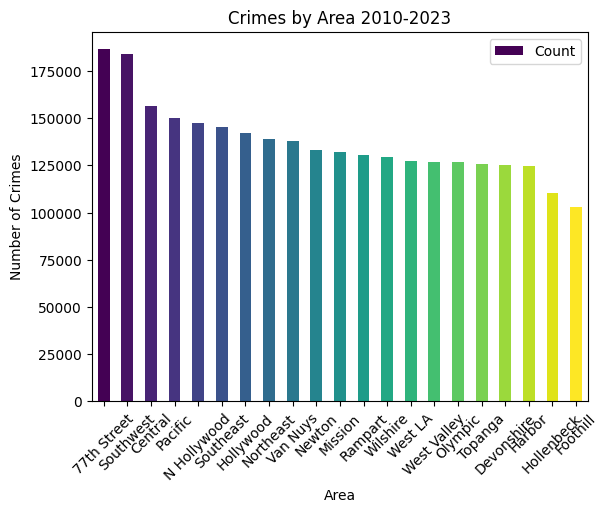

In [17]:
# Group by AREA and count the number of crimes
crimes_by_area = crime_df.groupby('AREA_NAME')['DR_NO'].count().reset_index(name='Count')


# Sort by crime count
crimes_by_area = crimes_by_area.sort_values('Count', ascending=False)

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(crimes_by_area)))

# Create a bar chart
plt.figure(figsize=(12, 6))
crimes_by_area.plot(kind='bar', x='AREA_NAME', y='Count', color=colors)

# Add labels and title
plt.title('Crimes by Area 2010-2023')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()


In [18]:
# To split crime_df into four separate datasets based on bureau category.

split_datasets = {}

categories = crime_df['AREA_NAME'].unique()
for category in categories:
  split_datasets[category] = crime_df[crime_df['AREA_NAME'] ==category]

SeventhStreet_dataset = split_datasets['77th Street']
Southwest_dataset = split_datasets['Southwest']
Central_dataset = split_datasets['Central']
Pacific_dataset = split_datasets['Pacific']
N_Hollywood_dataset = split_datasets['N Hollywood']
Southeast_dataset = split_datasets['Southeast']
Hollywood_dataset = split_datasets['Hollywood']
Northeast_dataset = split_datasets['Northeast']
Van_Nuys_dataset = split_datasets['Van Nuys']
Newton_dataset = split_datasets['Newton']
Mission_dataset = split_datasets['Mission']
Rampart_dataset = split_datasets['Rampart']
Wilshire_dataset = split_datasets['Wilshire']
West_LA_dataset = split_datasets['West LA']
West_Valley_dataset = split_datasets['West Valley']
Olympic_dataset = split_datasets['Olympic']
Topanga_dataset = split_datasets['Topanga']
Devonshire_dataset = split_datasets['Devonshire']
Harbor_dataset = split_datasets['Harbor']
Hollenbeck_dataset = split_datasets['Hollenbeck']
Foothill_dataset = split_datasets['Foothill']

In [19]:
SeventhStreet_dataset.head()

DR_NO               Date_Rptd  TIME_OCC  AREA    AREA_NAME  \
DATE_OCC                                                                     
2010-02-20  101207980  02/22/2010 12:00:00 AM       800    12  77th Street   
2010-02-20  101207910  02/20/2010 12:00:00 AM      2030    12  77th Street   
2010-02-20  101208127  02/24/2010 12:00:00 AM      1915    12  77th Street   
2010-02-20  101207941  02/22/2010 12:00:00 AM      2300    12  77th Street   
2010-02-20  101207892  02/21/2010 12:00:00 AM      1300    12  77th Street   

            Rpt_Dist_No  Part_1-2  Crm_Cd  \
DATE_OCC                                    
2010-02-20         1232         1     420   
2010-02-20         1269         2     946   
2010-02-20         1269         1     440   
2010-02-20         1205         2     626   
2010-02-20         1243         1     510   

                                                Crm_Cd_Desc  Vict_Age  ...  \
DATE_OCC                                                               ...   
2010-02-20  THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       0.0  ...   
2010-02-20                        OTHER MISCELLANEOUS CRIME       0.0  ...   
2010-02-20               THEFT PLAIN - PETTY ($950 & UNDER)      56.0  ...   
2010-02-20                INTIMATE PARTNER - SIMPLE ASSAULT      30.0  ...   
2010-02-20                                 VEHICLE - STOLEN       0.0  ...   

           Avg_Dewpoint Avg_Humidity Avg_Windspeed  Avg_Pressure  \
DATE_OCC                                                           
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   
2010-02-20         47.5         73.2           9.7          29.8   

            Total_Precipitation  Weapon_Reported  \
DATE_OCC                                           
2010-02-20                  0.0                0   
2010-02-20                  0.0                0   
2010-02-20                  0.0                0   
2010-02-20                  0.0                1   
2010-02-20                  0.0                0   

                                Crime_Category  Crime_Category_Code  \
DATE_OCC                                                              
2010-02-20                Miscellaneous Crimes                    2   
2010-02-20                Miscellaneous Crimes                    2   
2010-02-20                  Theft and Burglary                    5   
2010-02-20  Assault, Battery and Other Violent                    0   
2010-02-20                  Theft and Burglary                    5   

              Region_Ethnic_Origin  Crime_Incidence  
DATE_OCC                                             
2010-02-20                   Other               74  
2010-02-20                   Other               74  
2010-02-20                   Other               74  
2010-02-20  Hispanic/Latin/Mexican               74  
2010-02-20                   Other               74  

[5 rows x 26 columns]

**Using Neural Network's LSTM in TensorFlow to Predict Crime Incidence (Hotspot)**

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
import math
from math import floor,ceil,sqrt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [22]:
from keras.optimizers import Adam

**22. LSTM for Full Data (All Bureaus)**

In [47]:
def lstm_prediction(crime_df, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = crime_df.shape[0]
    df_new = crime_df[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------L.A. CITY-WIDE (ALL AREAS) CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('L.A. CITY-WIDE (ALL AREAS) CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------L.A. CITY-WIDE (ALL AREAS) CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (2307042, 1)
Shape of Validation Set (576760, 1)
Epoch 1/25
57676/57676 - 451s - loss: 0.0013 - val_loss: 6.6764e-04 - 451s/epoch - 8ms/step
Epoch 2/25
57676/57676 - 440s - loss: 0.0013 - val_loss: 6.6164e-04 - 440s/epoch - 8ms/step
Epoch 3/25
57676/57676 - 427s - loss: 0.0013 - val_loss: 6.6114e-04 - 427s/epoch - 7ms/step
Epoch 4/25
57676/57676 - 431s - loss: 0.0013 - val_loss: 6.5204e-04 - 431s/epoch - 7ms/step
Epoch 5/25
57676/57676 - 424s - loss: 0.0013 - val_loss: 6.4898e-04 - 424s/epoch - 7ms/step
Epoch 6/25
57676/57676 - 423s - loss: 0.0013 - val_loss: 6.5500e-04 - 423s/epoch - 7ms/step
Epoch 7/25
57676/57676 - 428s - loss: 0.0012 - val_loss: 6.6034e-0

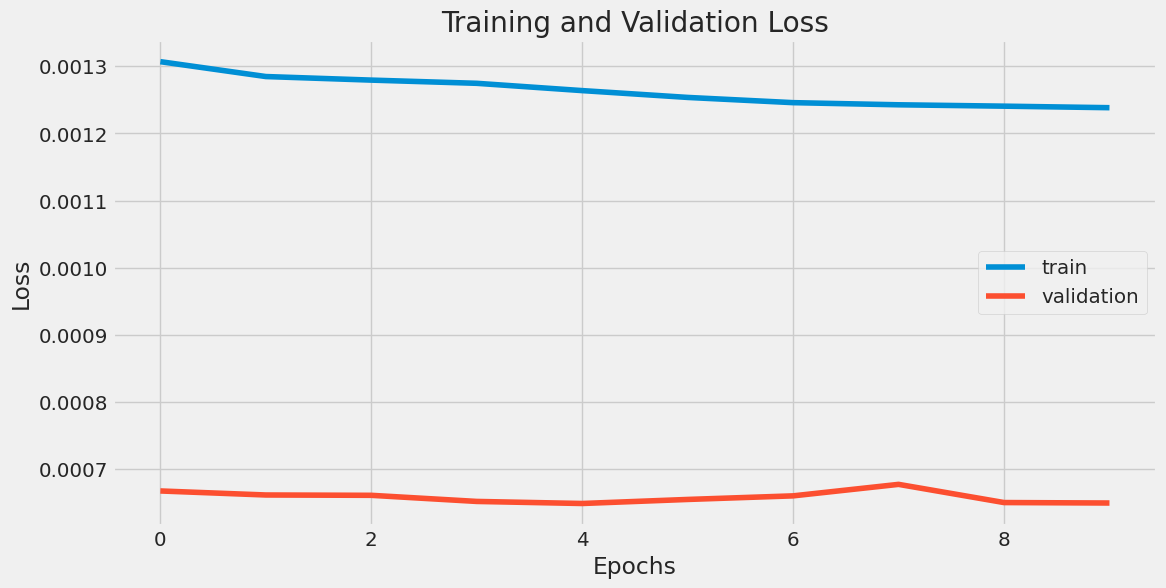

18024/18024 [==============================] - 55s 3ms/step
RMSE value on validation set: Crime_Incidence    16.548444
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


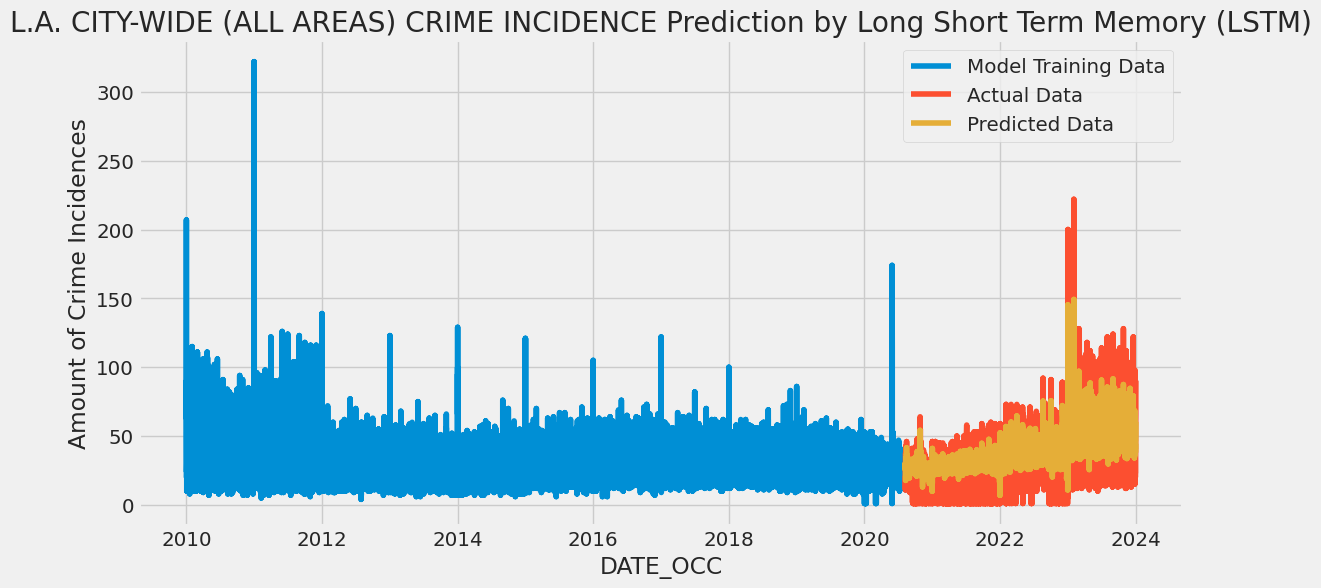

In [48]:
lstm_prediction(crime_df)

**1. LSTM for 77th Street Area**

In [49]:
def lstm_prediction(SeventhStreet_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = SeventhStreet_dataset.shape[0]
    df_new = SeventhStreet_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------77TH STREET AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('77TH STREET AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------77TH STREET AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (149114, 1)
Shape of Validation Set (37278, 1)
Epoch 1/25
3727/3727 - 30s - loss: 1.7659e-04 - val_loss: 2.2624e-04 - 30s/epoch - 8ms/step
Epoch 2/25
3727/3727 - 26s - loss: 9.0403e-05 - val_loss: 5.2083e-05 - 26s/epoch - 7ms/step
Epoch 3/25
3727/3727 - 26s - loss: 8.9004e-05 - val_loss: 5.2208e-05 - 26s/epoch - 7ms/step
Epoch 4/25
3727/3727 - 26s - loss: 8.5293e-05 - val_loss: 5.7582e-05 - 26s/epoch - 7ms/step
Epoch 5/25
3727/3727 - 27s - loss: 8.4738e-05 - val_loss: 5.6490e-05 - 27s/epoch - 7ms/step
Epoch 6/25
3727/3727 - 26s - loss: 8.3244e-05 - val_loss: 5.1088e-05 - 26s/epoch - 7ms/step
Epoch 7/25
3727/3727 - 26s - loss: 8.2919e-05 - val_loss: 5.1063e-05 - 26s/epo

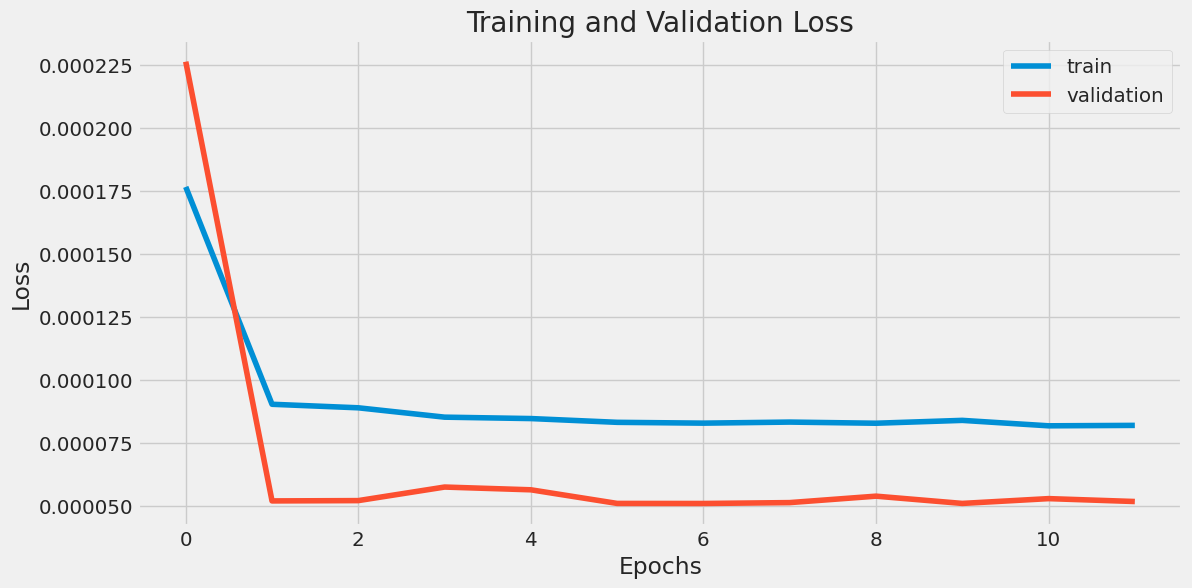

1165/1165 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    2.460825
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


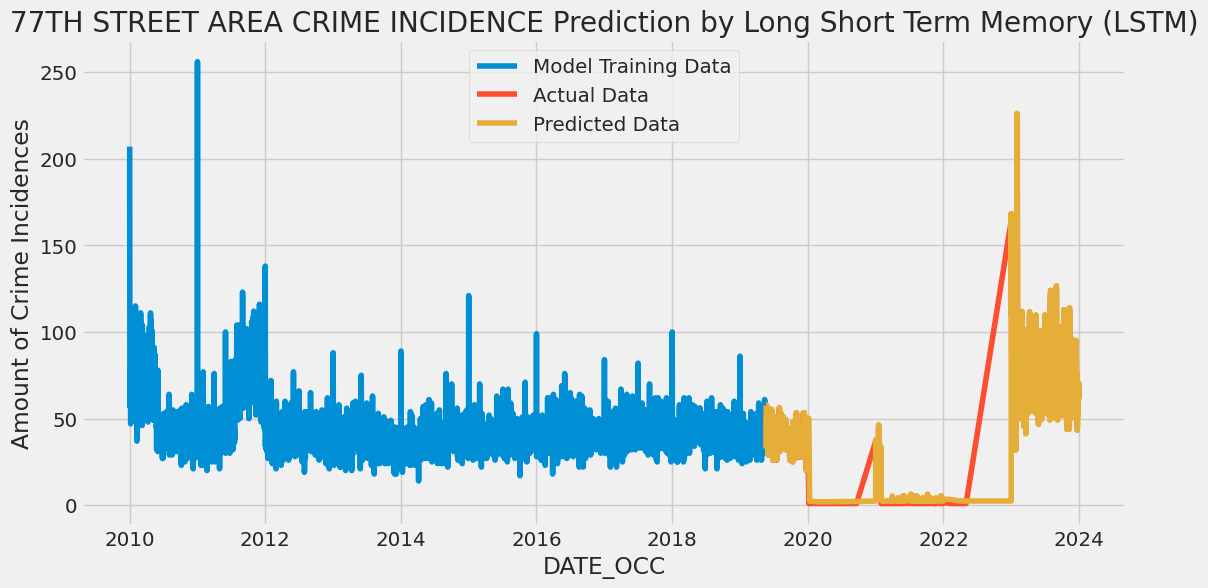

In [50]:
lstm_prediction(SeventhStreet_dataset)

**2. LSTM for Southwest Area**

In [51]:
def lstm_prediction(Southwest_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Southwest_dataset.shape[0]
    df_new = Southwest_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------SOUTHWEST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('SOUTHWEST AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------SOUTHWEST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (147259, 1)
Shape of Validation Set (36814, 1)
Epoch 1/25
3681/3681 - 29s - loss: 2.6784e-04 - val_loss: 1.3267e-04 - 29s/epoch - 8ms/step
Epoch 2/25
3681/3681 - 26s - loss: 1.6860e-04 - val_loss: 1.0819e-04 - 26s/epoch - 7ms/step
Epoch 3/25
3681/3681 - 25s - loss: 1.5831e-04 - val_loss: 9.7724e-05 - 25s/epoch - 7ms/step
Epoch 4/25
3681/3681 - 26s - loss: 1.5586e-04 - val_loss: 1.0552e-04 - 26s/epoch - 7ms/step
Epoch 5/25
3681/3681 - 26s - loss: 1.5349e-04 - val_loss: 1.0119e-04 - 26s/epoch - 7ms/step
Epoch 6/25
3681/3681 - 26s - loss: 1.5289e-04 - val_loss: 1.0341e-04 - 26s/epoch - 7ms/step
Epoch 7/25
3681/3681 - 26s - loss: 1.5053e-04 - val_loss: 1.0046e-04 - 26s/epoch

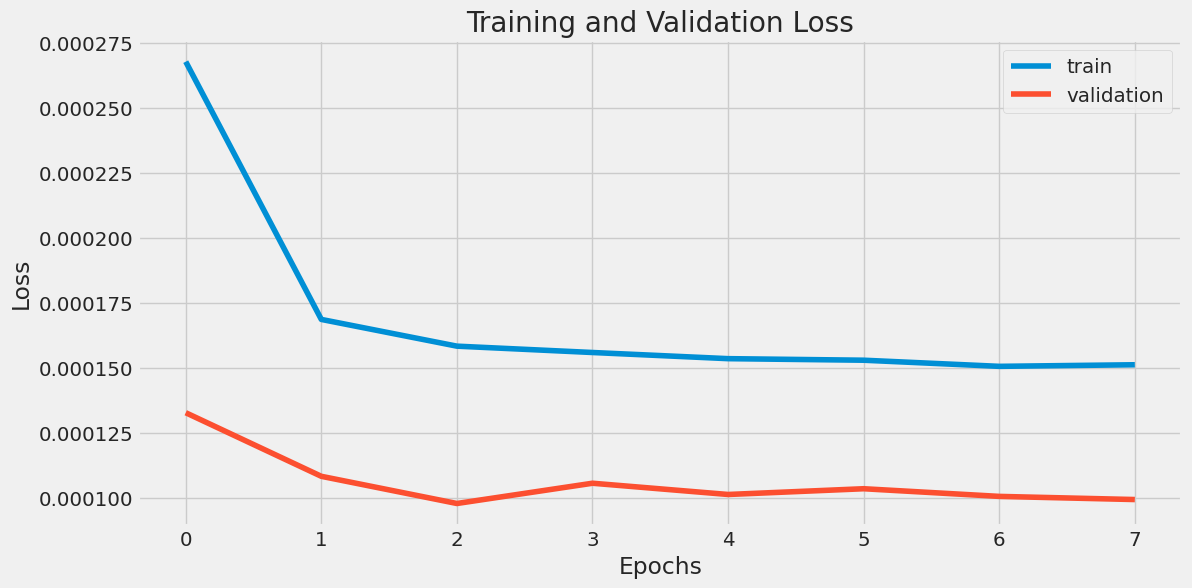

1151/1151 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    1.921022
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


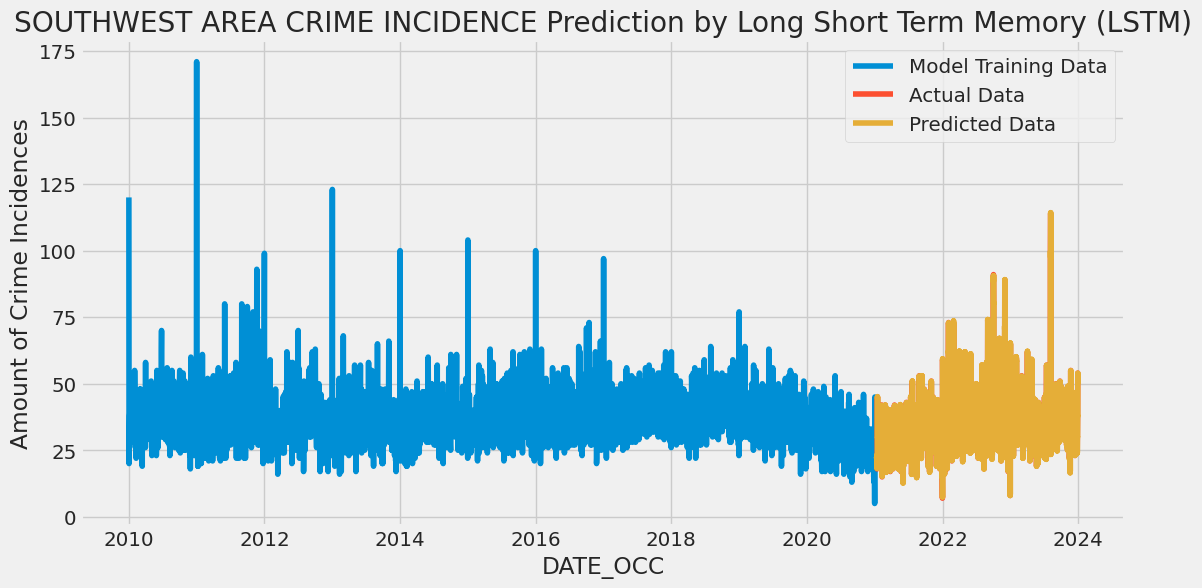

In [52]:
lstm_prediction(Southwest_dataset)

**3. LSTM for Central Area**

In [45]:
def lstm_prediction(Central_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Central_dataset.shape[0]
    df_new = Central_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------CENTRAL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('CENTRAL AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------CENTRAL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (125328, 1)
Shape of Validation Set (31331, 1)
Epoch 1/25
3133/3133 - 27s - loss: 1.7440e-04 - val_loss: 1.2657e-04 - 27s/epoch - 9ms/step
Epoch 2/25
3133/3133 - 22s - loss: 1.1020e-04 - val_loss: 1.6585e-04 - 22s/epoch - 7ms/step
Epoch 3/25
3133/3133 - 23s - loss: 1.0739e-04 - val_loss: 1.2749e-04 - 23s/epoch - 7ms/step
Epoch 4/25
3133/3133 - 23s - loss: 1.0491e-04 - val_loss: 1.2881e-04 - 23s/epoch - 7ms/step
Epoch 5/25
3133/3133 - 22s - loss: 1.0417e-04 - val_loss: 1.3660e-04 - 22s/epoch - 7ms/step
Epoch 6/25
3133/3133 - 23s - loss: 1.0347e-04 - val_loss: 1.9070e-04 - 23s/epoch - 7ms/step


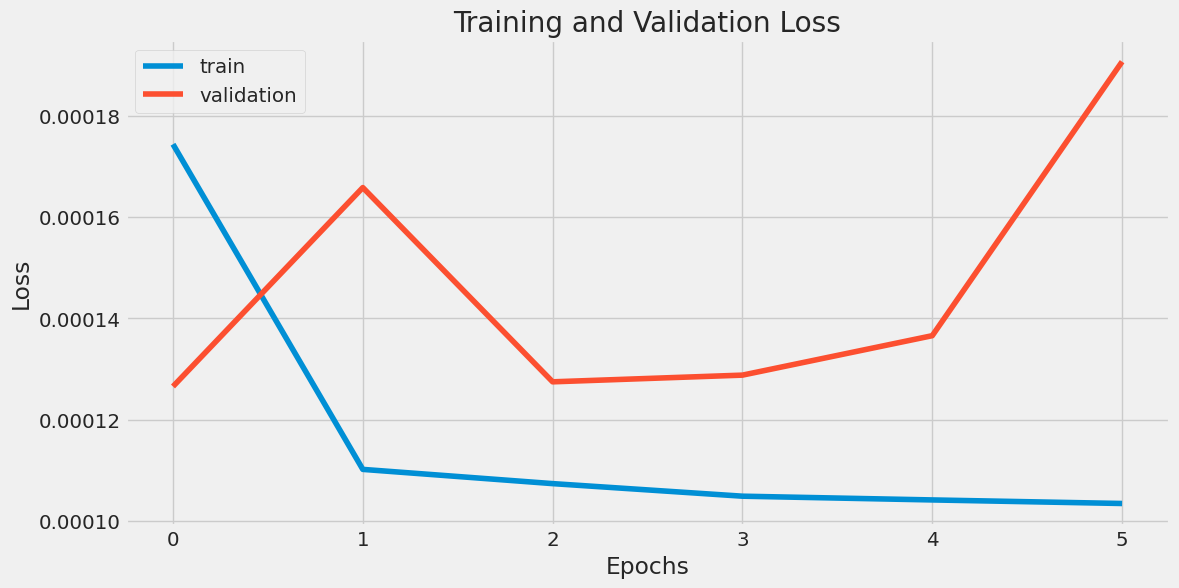

980/980 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    1.718368
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


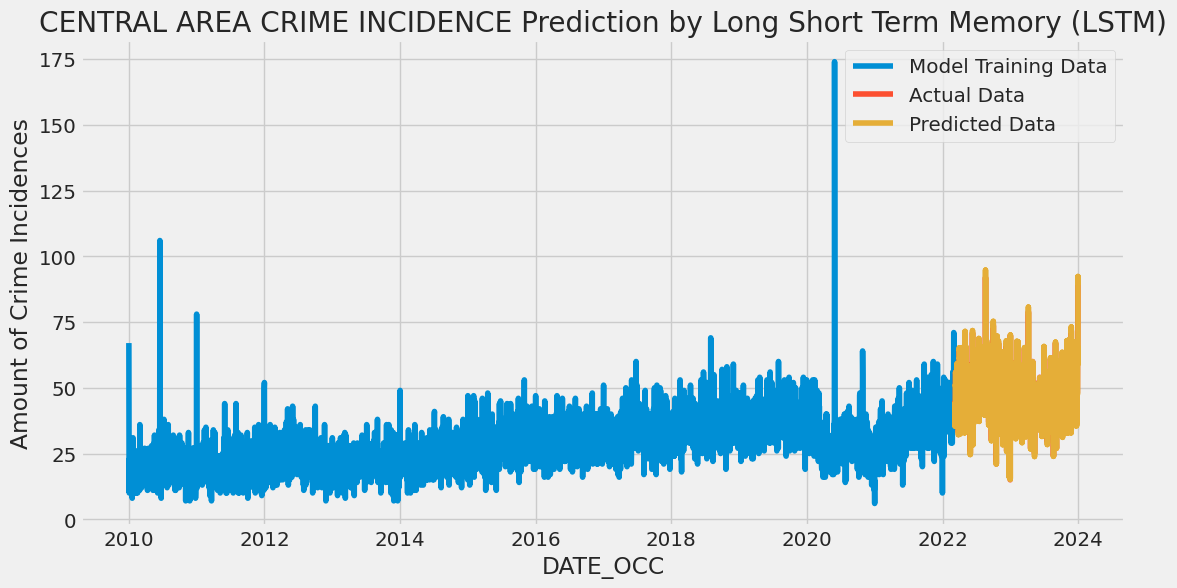

In [46]:
lstm_prediction(Central_dataset)

**4. LSTM for Pacific Area**

In [53]:
def lstm_prediction(Pacific_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Pacific_dataset.shape[0]
    df_new = Pacific_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------PACIFIC AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('PACIFIC AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------PACIFIC AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (120004, 1)
Shape of Validation Set (30001, 1)
Epoch 1/25
3000/3000 - 25s - loss: 4.5947e-04 - val_loss: 1.7326e-04 - 25s/epoch - 8ms/step
Epoch 2/25
3000/3000 - 21s - loss: 2.8069e-04 - val_loss: 1.6675e-04 - 21s/epoch - 7ms/step
Epoch 3/25
3000/3000 - 21s - loss: 2.7239e-04 - val_loss: 2.9027e-04 - 21s/epoch - 7ms/step
Epoch 4/25
3000/3000 - 20s - loss: 2.6605e-04 - val_loss: 1.6607e-04 - 20s/epoch - 7ms/step
Epoch 5/25
3000/3000 - 20s - loss: 2.6658e-04 - val_loss: 1.8044e-04 - 20s/epoch - 7ms/step
Epoch 6/25
3000/3000 - 20s - loss: 2.6232e-04 - val_loss: 1.6895e-04 - 20s/epoch - 7ms/step
Epoch 7/25
3000/3000 - 21s - loss: 2.6307e-04 - val_loss: 1.7769e-04 - 21s/epoch -

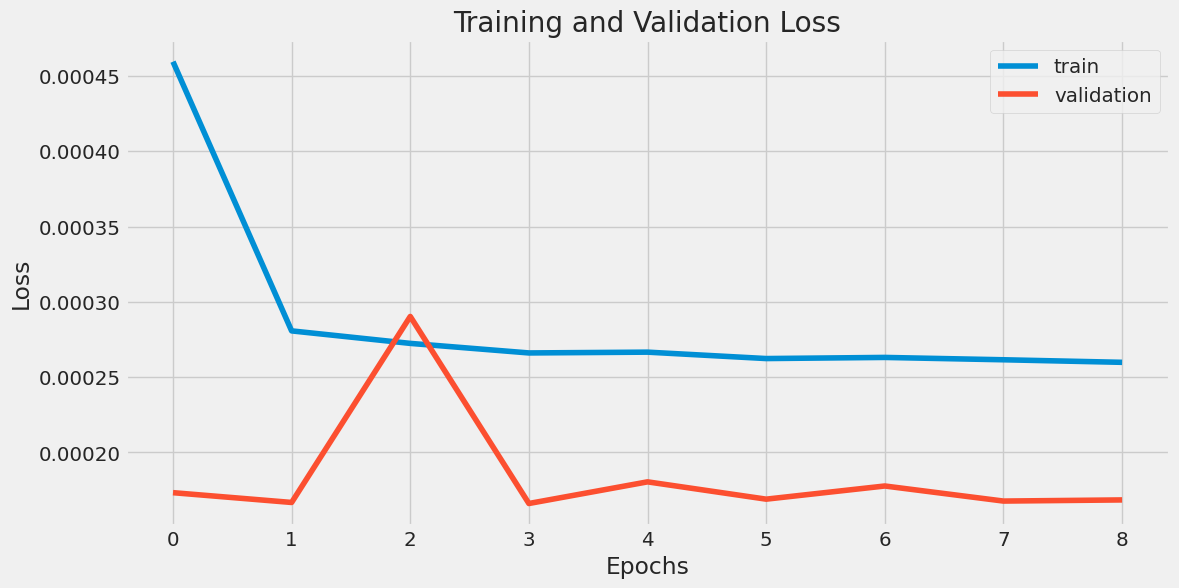

938/938 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.362003
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


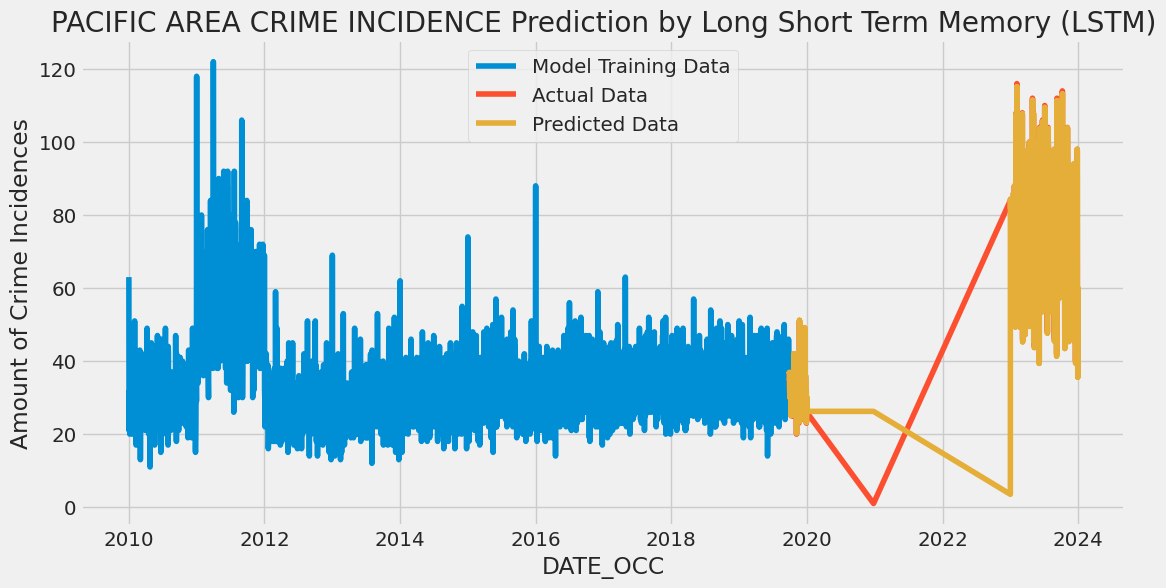

In [54]:
lstm_prediction(Pacific_dataset)

**5. LSTM for N Hollywood Area**

In [55]:
def lstm_prediction(N_Hollywood_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = N_Hollywood_dataset.shape[0]
    df_new = N_Hollywood_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------NORTH HOLLYWOOD AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('NORTH HOLLYWOOD AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------NORTH HOLLYWOOD AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (118016, 1)
Shape of Validation Set (29503, 1)
Epoch 1/25
2950/2950 - 24s - loss: 1.9551e-04 - val_loss: 4.2682e-05 - 24s/epoch - 8ms/step
Epoch 2/25
2950/2950 - 21s - loss: 9.7810e-05 - val_loss: 6.5174e-05 - 21s/epoch - 7ms/step
Epoch 3/25
2950/2950 - 21s - loss: 9.6487e-05 - val_loss: 8.0181e-05 - 21s/epoch - 7ms/step
Epoch 4/25
2950/2950 - 20s - loss: 9.4627e-05 - val_loss: 3.7876e-05 - 20s/epoch - 7ms/step
Epoch 5/25
2950/2950 - 21s - loss: 9.4534e-05 - val_loss: 7.0760e-05 - 21s/epoch - 7ms/step
Epoch 6/25
2950/2950 - 20s - loss: 9.0272e-05 - val_loss: 3.8710e-05 - 20s/epoch - 7ms/step
Epoch 7/25
2950/2950 - 20s - loss: 9.0228e-05 - val_loss: 4.5700e-05 - 20s

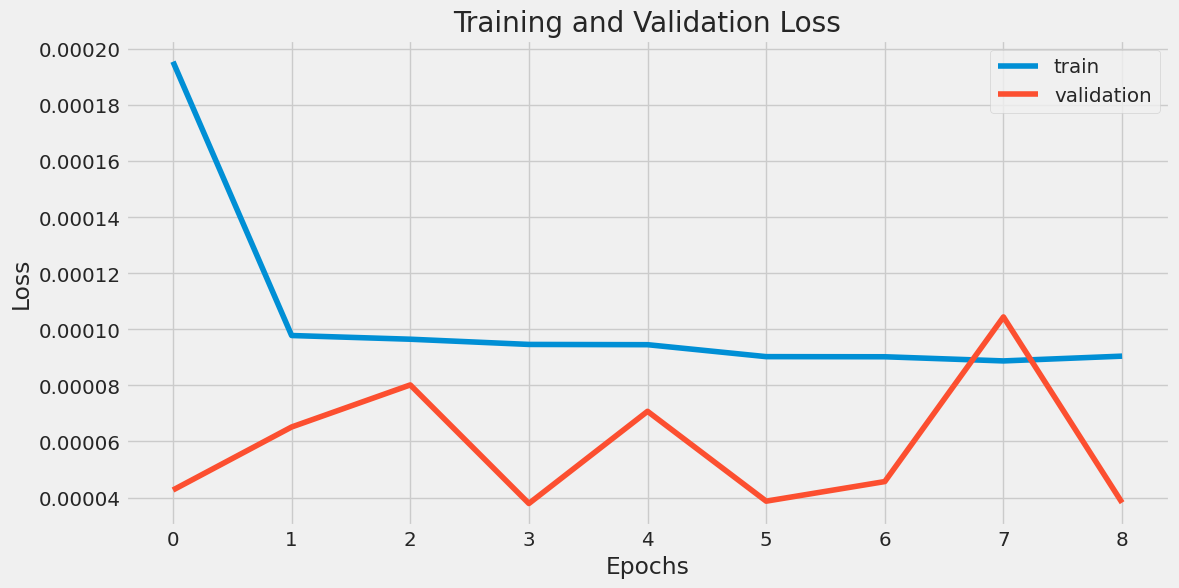

922/922 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    2.397087
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


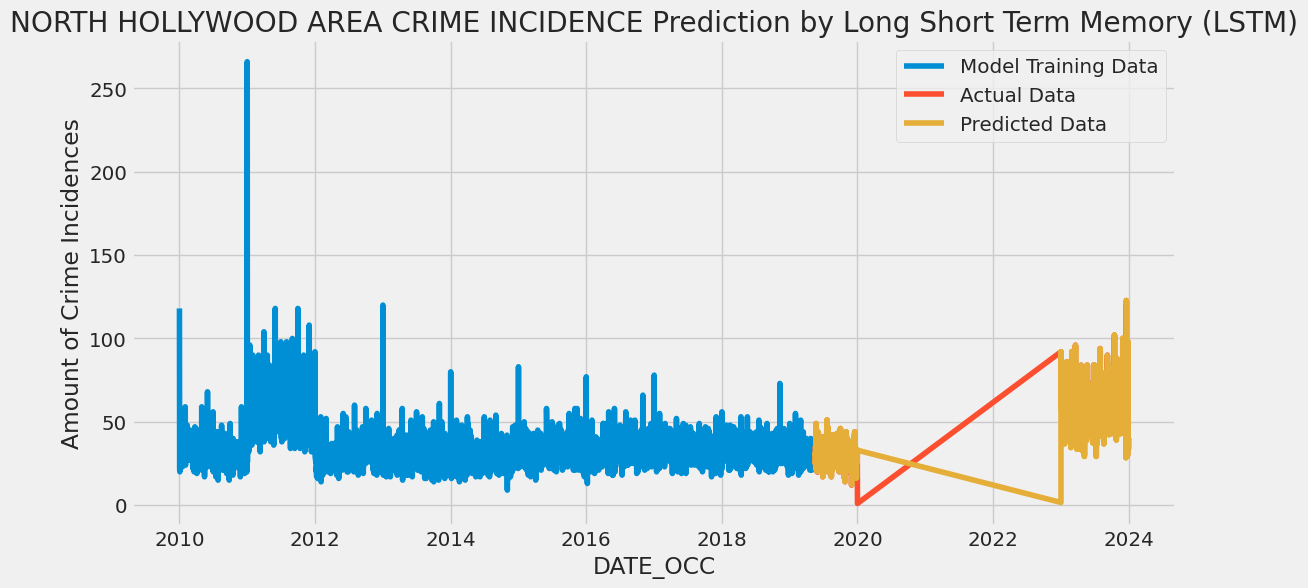

In [56]:
lstm_prediction(N_Hollywood_dataset)

**6. LSTM for Southeast Area**

In [57]:
def lstm_prediction(Southeast_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Southeast_dataset.shape[0]
    df_new = Southeast_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------SOUTHEAST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('SOUTHEAST AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------SOUTHEAST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (116121, 1)
Shape of Validation Set (29030, 1)
Epoch 1/25
2902/2902 - 23s - loss: 1.8530e-04 - val_loss: 5.5328e-05 - 23s/epoch - 8ms/step
Epoch 2/25
2902/2902 - 20s - loss: 8.9693e-05 - val_loss: 5.4225e-05 - 20s/epoch - 7ms/step
Epoch 3/25
2902/2902 - 20s - loss: 8.9914e-05 - val_loss: 4.6824e-05 - 20s/epoch - 7ms/step
Epoch 4/25
2902/2902 - 19s - loss: 8.8108e-05 - val_loss: 4.9497e-05 - 19s/epoch - 7ms/step
Epoch 5/25
2902/2902 - 19s - loss: 8.5411e-05 - val_loss: 5.4484e-05 - 19s/epoch - 7ms/step
Epoch 6/25
2902/2902 - 19s - loss: 8.4319e-05 - val_loss: 5.1638e-05 - 19s/epoch - 7ms/step
Epoch 7/25
2902/2902 - 19s - loss: 8.3650e-05 - val_loss: 4.6712e-05 - 19s/epoch

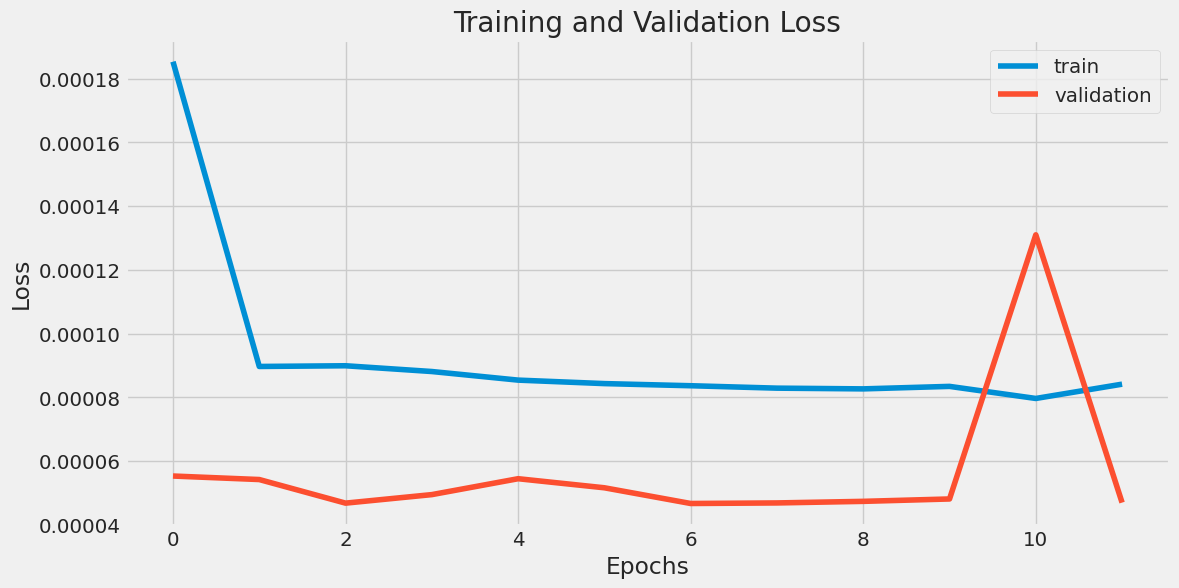

908/908 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.630606
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


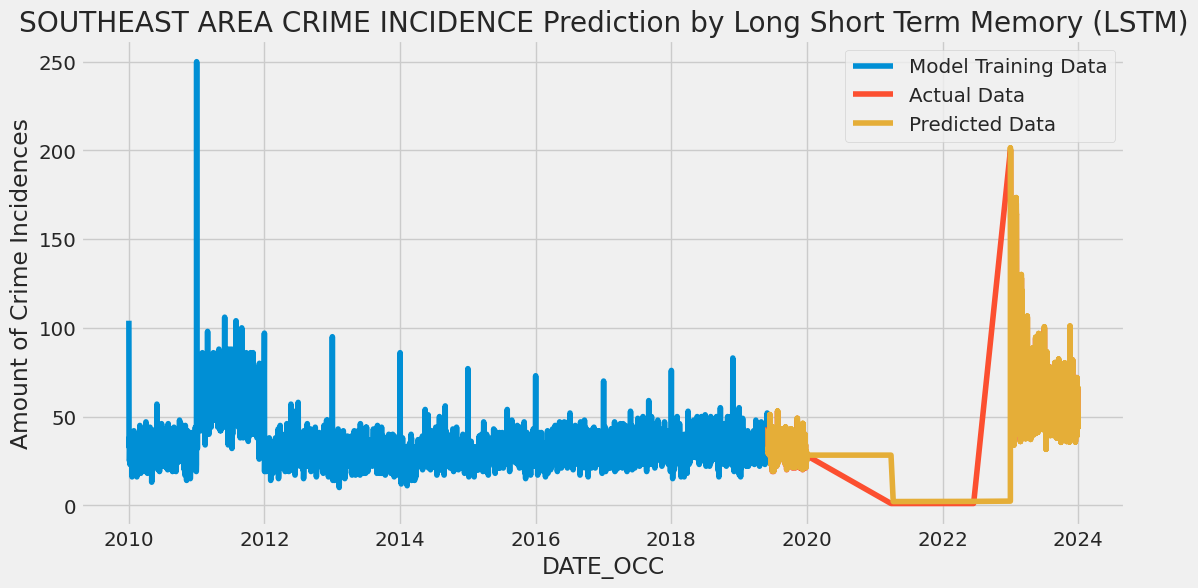

In [58]:
lstm_prediction(Southeast_dataset)

**7. LSTM for Hollywood Area**

In [59]:
def lstm_prediction(Hollywood_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Hollywood_dataset.shape[0]
    df_new = Hollywood_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------HOLLYWOOD AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('HOLLYWOOD AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------HOLLYWOOD AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (113664, 1)
Shape of Validation Set (28415, 1)
Epoch 1/25
2841/2841 - 24s - loss: 2.2949e-04 - val_loss: 7.7974e-05 - 24s/epoch - 9ms/step
Epoch 2/25
2841/2841 - 20s - loss: 1.3308e-04 - val_loss: 7.2601e-05 - 20s/epoch - 7ms/step
Epoch 3/25
2841/2841 - 20s - loss: 1.3130e-04 - val_loss: 7.7892e-05 - 20s/epoch - 7ms/step
Epoch 4/25
2841/2841 - 20s - loss: 1.2488e-04 - val_loss: 6.7691e-05 - 20s/epoch - 7ms/step
Epoch 5/25
2841/2841 - 21s - loss: 1.2099e-04 - val_loss: 7.0998e-05 - 21s/epoch - 7ms/step
Epoch 6/25
2841/2841 - 20s - loss: 1.2375e-04 - val_loss: 6.8068e-05 - 20s/epoch - 7ms/step
Epoch 7/25
2841/2841 - 20s - loss: 1.2014e-04 - val_loss: 7.0679e-05 - 20s/epoch

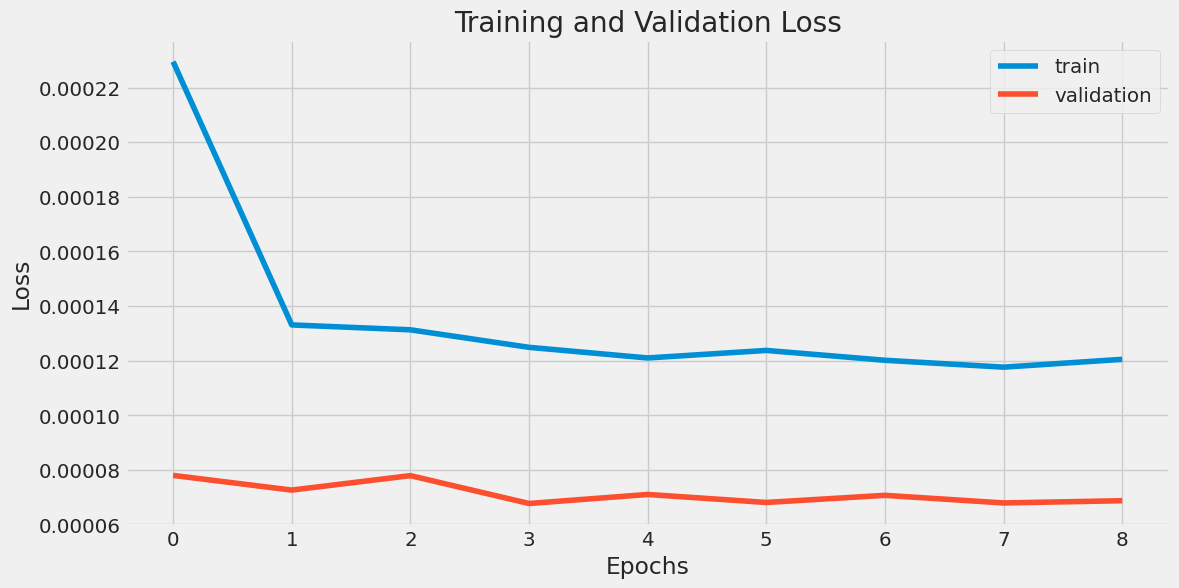

888/888 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.238715
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


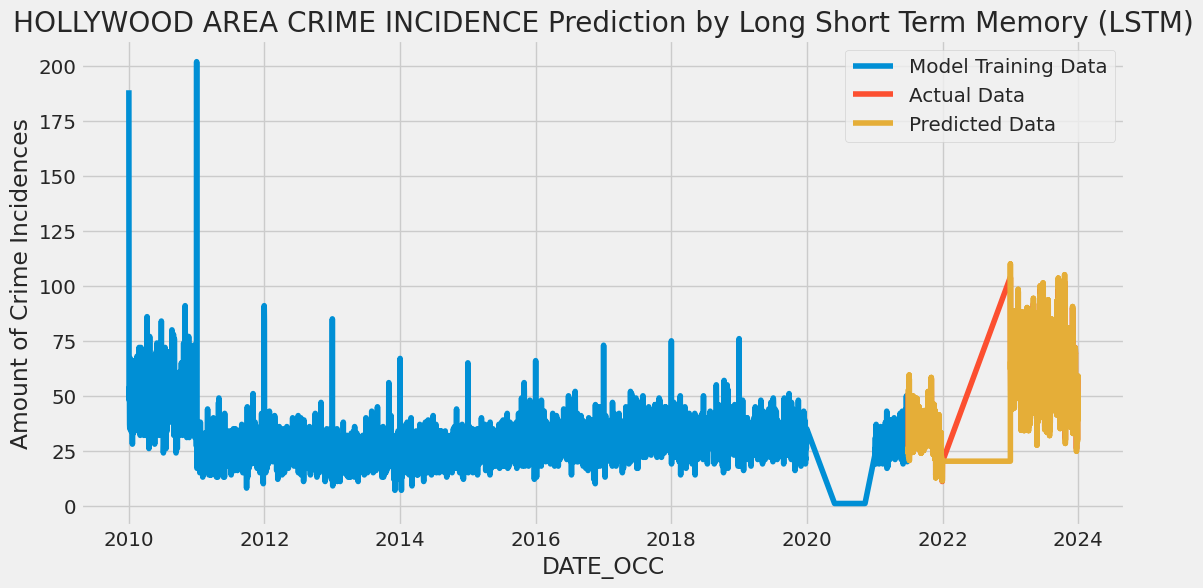

In [60]:
lstm_prediction(Hollywood_dataset)

**8. LSTM for Northeast Area**

In [61]:
def lstm_prediction(Northeast_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Northeast_dataset.shape[0]
    df_new = Northeast_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------NORTHEAST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('NORTHEAST AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------NORTHEAST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (111328, 1)
Shape of Validation Set (27831, 1)
Epoch 1/25
2783/2783 - 24s - loss: 2.3933e-04 - val_loss: 7.7407e-05 - 24s/epoch - 8ms/step
Epoch 2/25
2783/2783 - 19s - loss: 1.4852e-04 - val_loss: 1.2718e-04 - 19s/epoch - 7ms/step
Epoch 3/25
2783/2783 - 19s - loss: 1.4368e-04 - val_loss: 7.7301e-05 - 19s/epoch - 7ms/step
Epoch 4/25
2783/2783 - 19s - loss: 1.4001e-04 - val_loss: 8.0708e-05 - 19s/epoch - 7ms/step
Epoch 5/25
2783/2783 - 19s - loss: 1.3816e-04 - val_loss: 7.8287e-05 - 19s/epoch - 7ms/step
Epoch 6/25
2783/2783 - 20s - loss: 1.3629e-04 - val_loss: 7.6105e-05 - 20s/epoch - 7ms/step
Epoch 7/25
2783/2783 - 19s - loss: 1.3560e-04 - val_loss: 1.4967e-04 - 19s/epoch

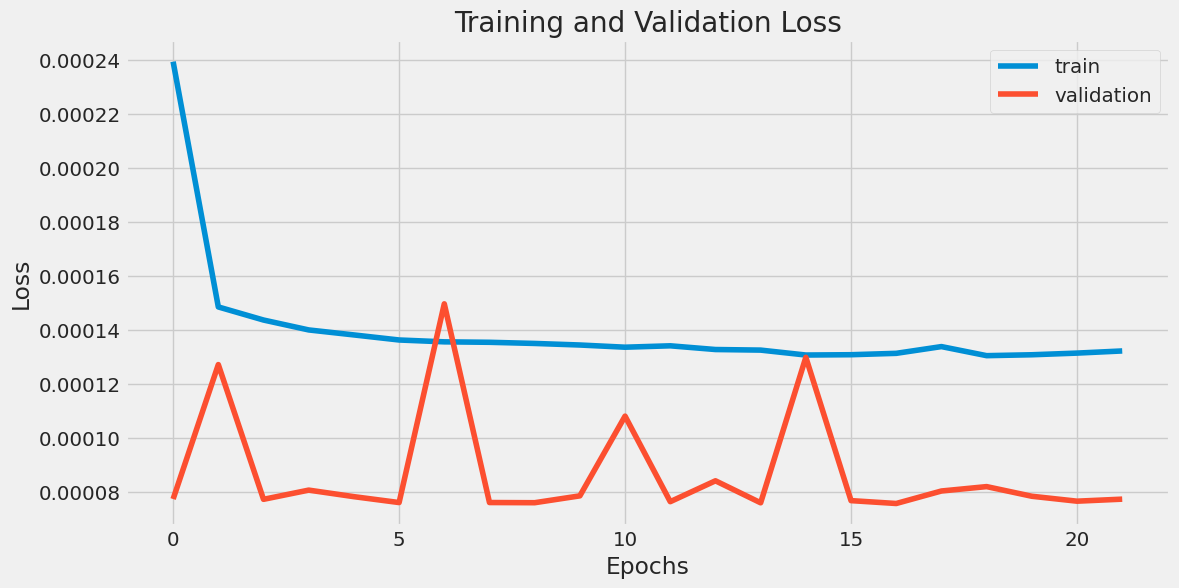

870/870 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.221796
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


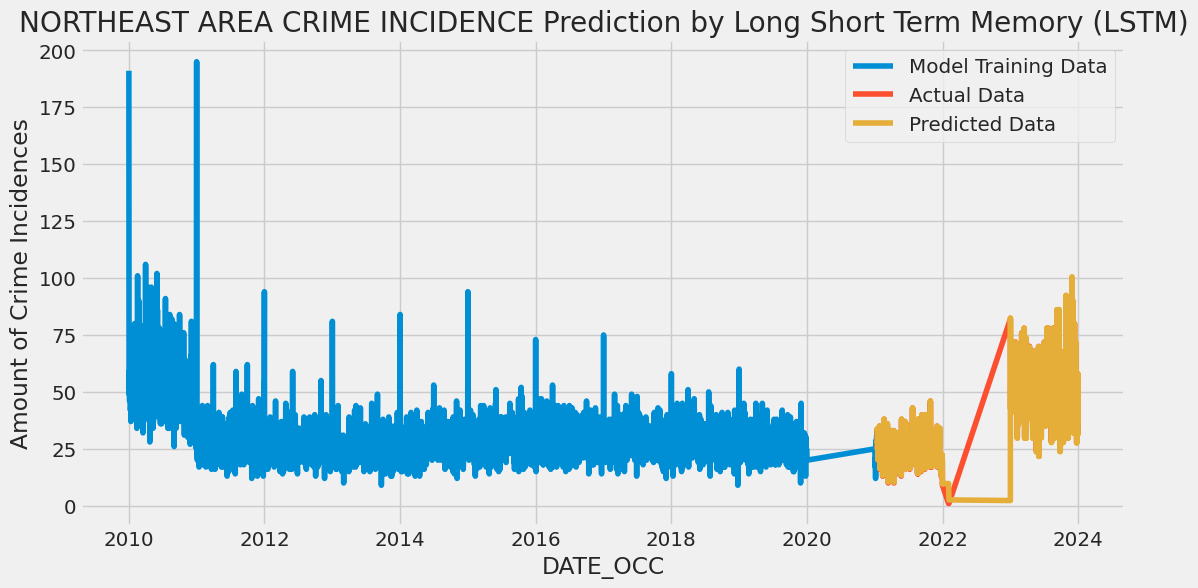

In [62]:
lstm_prediction(Northeast_dataset)

**9. LSTM for Van Nuys Area**

In [63]:
def lstm_prediction(Van_Nuys_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Van_Nuys_dataset.shape[0]
    df_new = Van_Nuys_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------VAN NUYS AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('VAN NUYS AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------VAN NUYS AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (110270, 1)
Shape of Validation Set (27567, 1)
Epoch 1/25
2756/2756 - 24s - loss: 1.9587e-04 - val_loss: 5.9634e-05 - 24s/epoch - 9ms/step
Epoch 2/25
2756/2756 - 19s - loss: 1.2887e-04 - val_loss: 1.9726e-04 - 19s/epoch - 7ms/step
Epoch 3/25
2756/2756 - 19s - loss: 1.2069e-04 - val_loss: 7.8317e-05 - 19s/epoch - 7ms/step
Epoch 4/25
2756/2756 - 18s - loss: 1.1988e-04 - val_loss: 1.1477e-04 - 18s/epoch - 7ms/step
Epoch 5/25
2756/2756 - 19s - loss: 1.1959e-04 - val_loss: 5.7867e-05 - 19s/epoch - 7ms/step
Epoch 6/25
2756/2756 - 19s - loss: 1.1825e-04 - val_loss: 5.9898e-05 - 19s/epoch - 7ms/step
Epoch 7/25
2756/2756 - 19s - loss: 1.1353e-04 - val_loss: 5.8041e-05 - 19s/epoch 

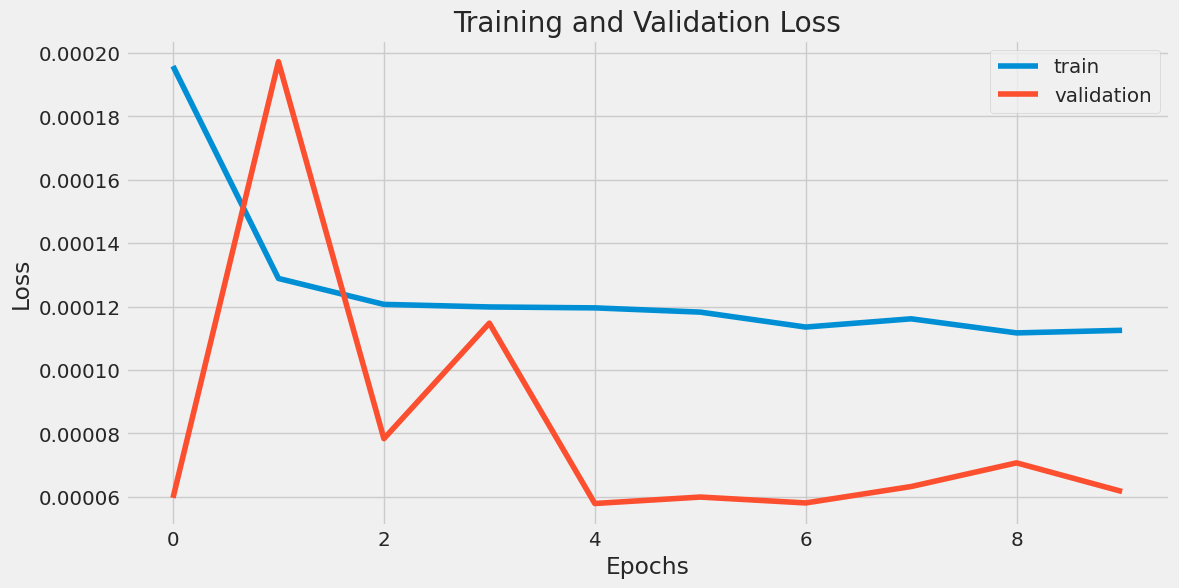

862/862 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.234512
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


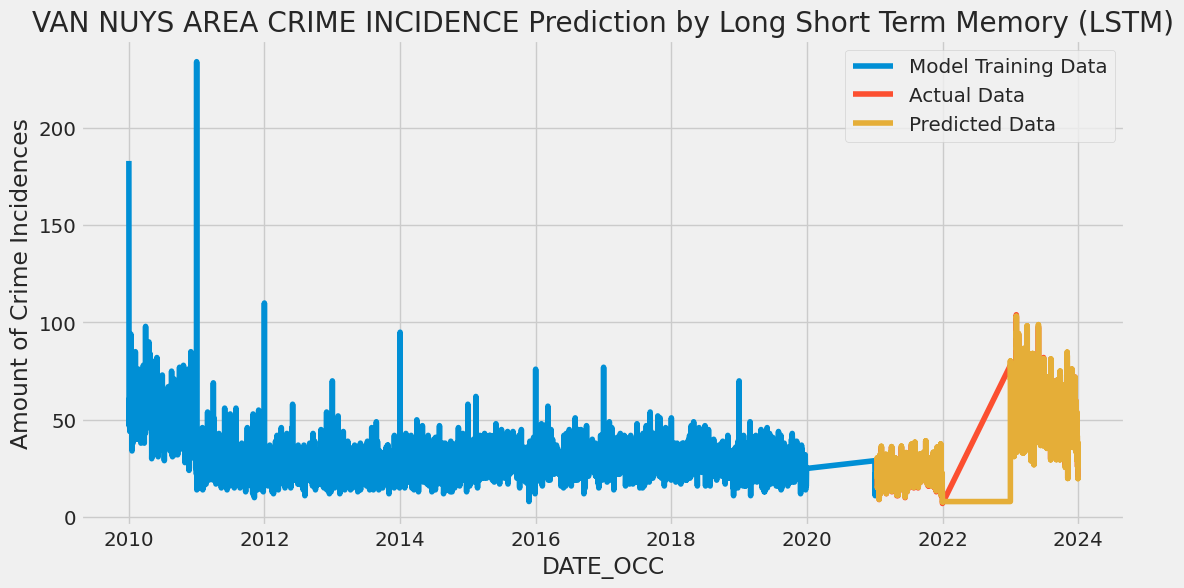

In [64]:
lstm_prediction(Van_Nuys_dataset)

**10. LSTM for Newton Area**

In [65]:
def lstm_prediction(Newton_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Newton_dataset.shape[0]
    df_new = Newton_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------NEWTON AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('NEWTON AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------NEWTON AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (106571, 1)
Shape of Validation Set (26642, 1)
Epoch 1/25
2664/2664 - 22s - loss: 2.5757e-04 - val_loss: 9.7231e-05 - 22s/epoch - 8ms/step
Epoch 2/25
2664/2664 - 19s - loss: 1.5277e-04 - val_loss: 8.8366e-05 - 19s/epoch - 7ms/step
Epoch 3/25
2664/2664 - 19s - loss: 1.4691e-04 - val_loss: 9.0077e-05 - 19s/epoch - 7ms/step
Epoch 4/25
2664/2664 - 19s - loss: 1.4392e-04 - val_loss: 9.2602e-05 - 19s/epoch - 7ms/step
Epoch 5/25
2664/2664 - 20s - loss: 1.4318e-04 - val_loss: 9.1045e-05 - 20s/epoch - 7ms/step
Epoch 6/25
2664/2664 - 19s - loss: 1.4075e-04 - val_loss: 9.7374e-05 - 19s/epoch - 7ms/step
Epoch 7/25
2664/2664 - 19s - loss: 1.4095e-04 - val_loss: 8.8168e-05 - 19s/epoch - 

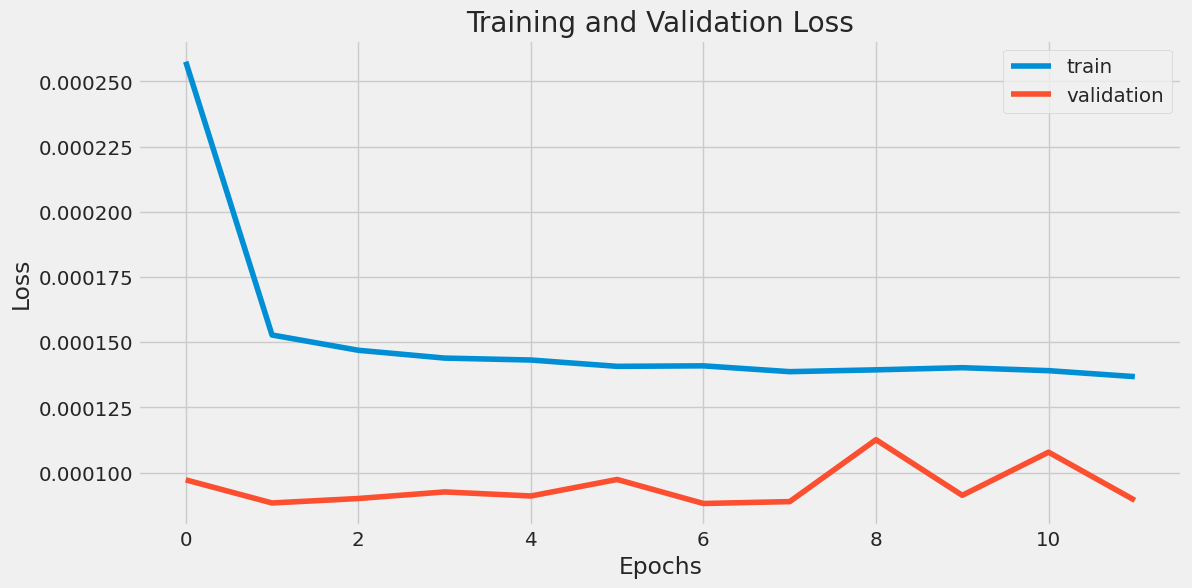

833/833 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.429205
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


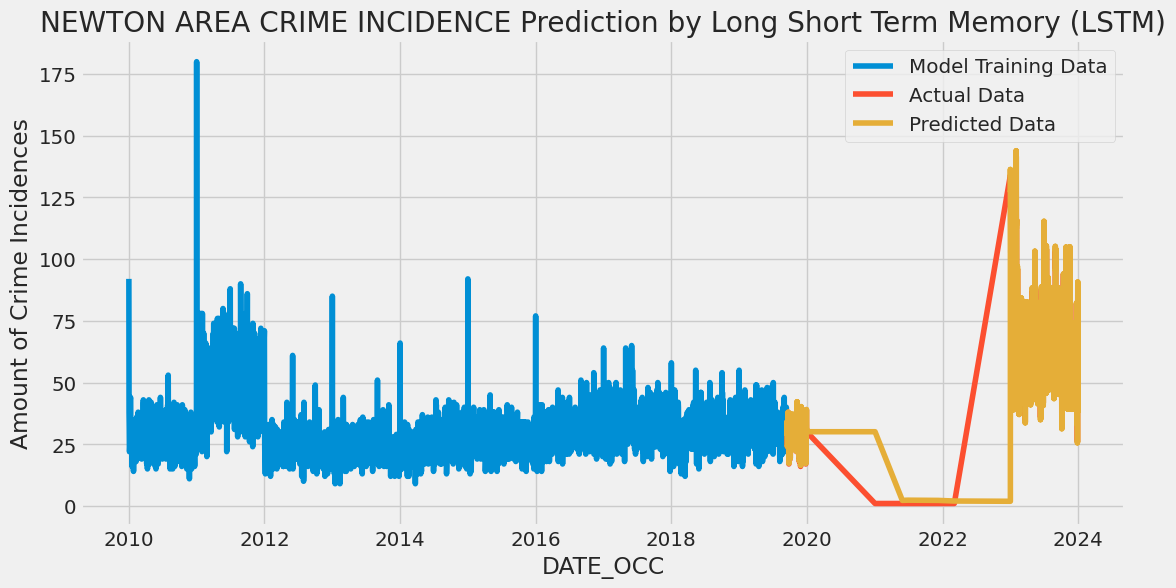

In [66]:
lstm_prediction(Newton_dataset)

**11. LSTM for Mission Area**

In [67]:
def lstm_prediction(Mission_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Mission_dataset.shape[0]
    df_new = Mission_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------MISSION AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('MISSION AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------MISSION AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (105668, 1)
Shape of Validation Set (26416, 1)
Epoch 1/25
2641/2641 - 23s - loss: 1.8853e-04 - val_loss: 4.6946e-05 - 23s/epoch - 9ms/step
Epoch 2/25
2641/2641 - 19s - loss: 1.0420e-04 - val_loss: 4.7474e-05 - 19s/epoch - 7ms/step
Epoch 3/25
2641/2641 - 18s - loss: 1.0382e-04 - val_loss: 4.9170e-05 - 18s/epoch - 7ms/step
Epoch 4/25
2641/2641 - 18s - loss: 1.0214e-04 - val_loss: 4.7577e-05 - 18s/epoch - 7ms/step
Epoch 5/25
2641/2641 - 18s - loss: 1.0011e-04 - val_loss: 5.4315e-05 - 18s/epoch - 7ms/step
Epoch 6/25
2641/2641 - 18s - loss: 9.6300e-05 - val_loss: 4.7055e-05 - 18s/epoch - 7ms/step


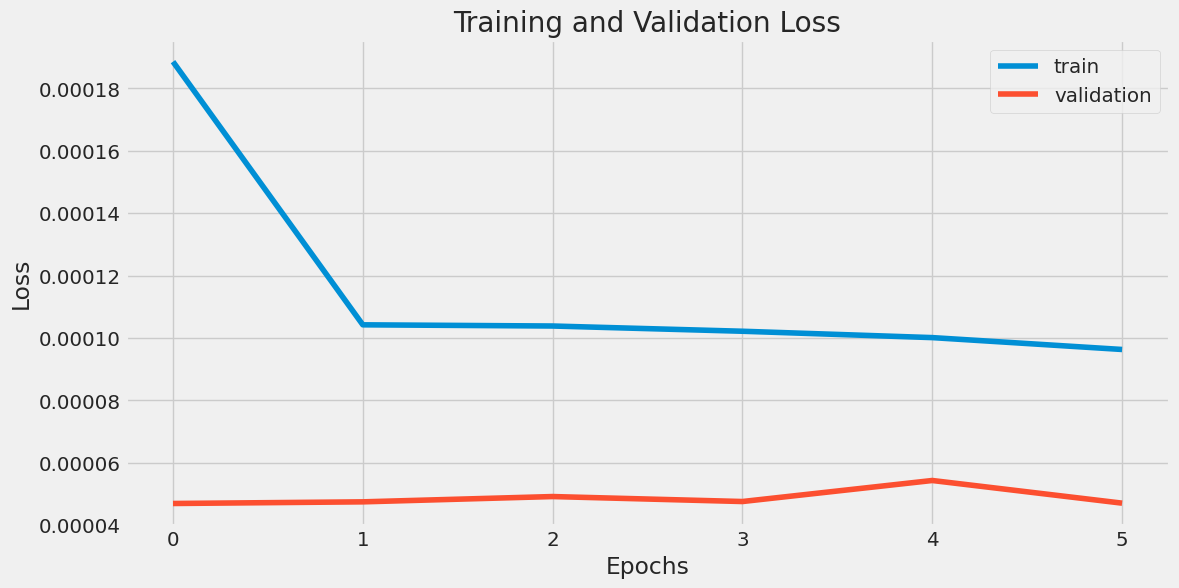

826/826 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.347
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


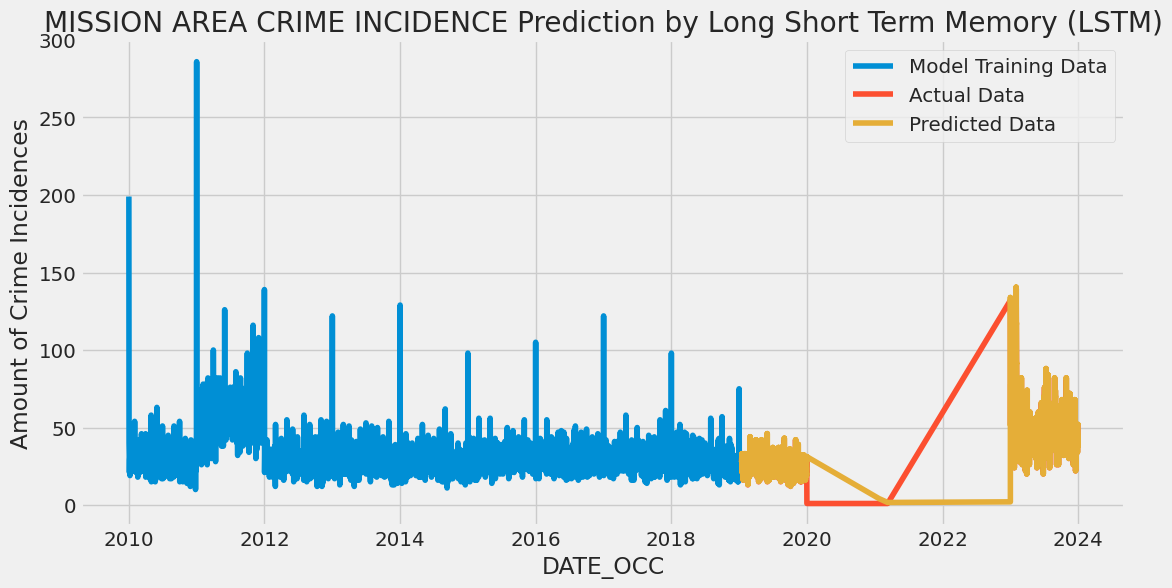

In [68]:
lstm_prediction(Mission_dataset)

**12. LSTM for Rampart Area**

In [69]:
def lstm_prediction(Rampart_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Rampart_dataset.shape[0]
    df_new = Rampart_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------RAMPART AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('RAMPART AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------RAMPART AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (104296, 1)
Shape of Validation Set (26073, 1)
Epoch 1/25
2607/2607 - 22s - loss: 2.7649e-04 - val_loss: 1.7558e-04 - 22s/epoch - 8ms/step
Epoch 2/25
2607/2607 - 19s - loss: 1.6748e-04 - val_loss: 1.0235e-04 - 19s/epoch - 7ms/step
Epoch 3/25
2607/2607 - 18s - loss: 1.7082e-04 - val_loss: 9.5034e-05 - 18s/epoch - 7ms/step
Epoch 4/25
2607/2607 - 18s - loss: 1.6908e-04 - val_loss: 1.0157e-04 - 18s/epoch - 7ms/step
Epoch 5/25
2607/2607 - 18s - loss: 1.6089e-04 - val_loss: 9.7815e-05 - 18s/epoch - 7ms/step
Epoch 6/25
2607/2607 - 18s - loss: 1.5573e-04 - val_loss: 1.1190e-04 - 18s/epoch - 7ms/step
Epoch 7/25
2607/2607 - 18s - loss: 1.6036e-04 - val_loss: 9.6742e-05 - 18s/epoch -

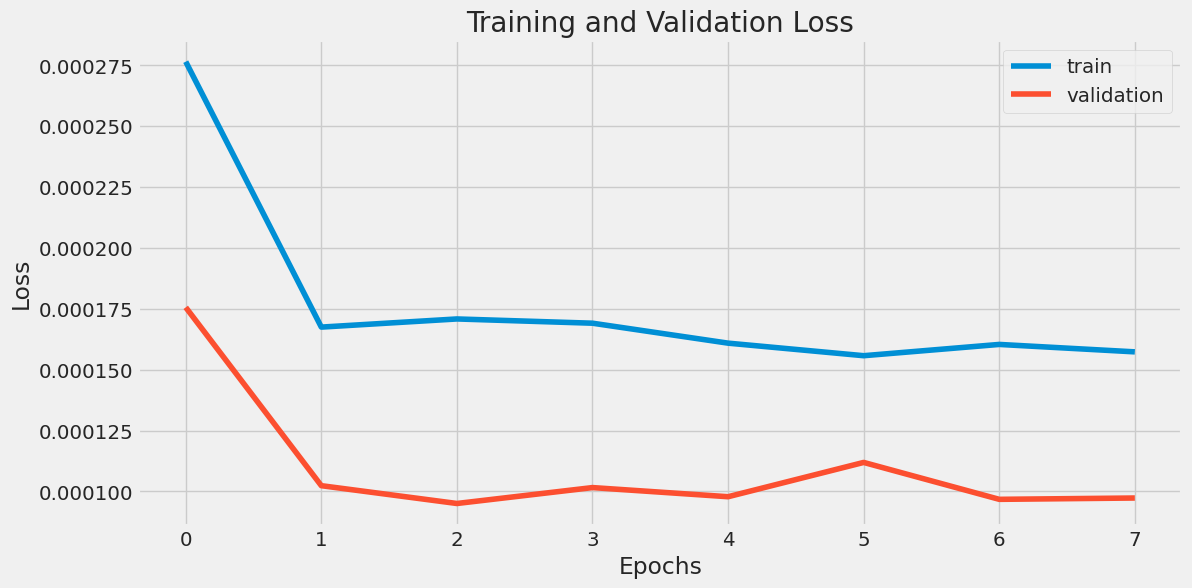

815/815 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    1.728974
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


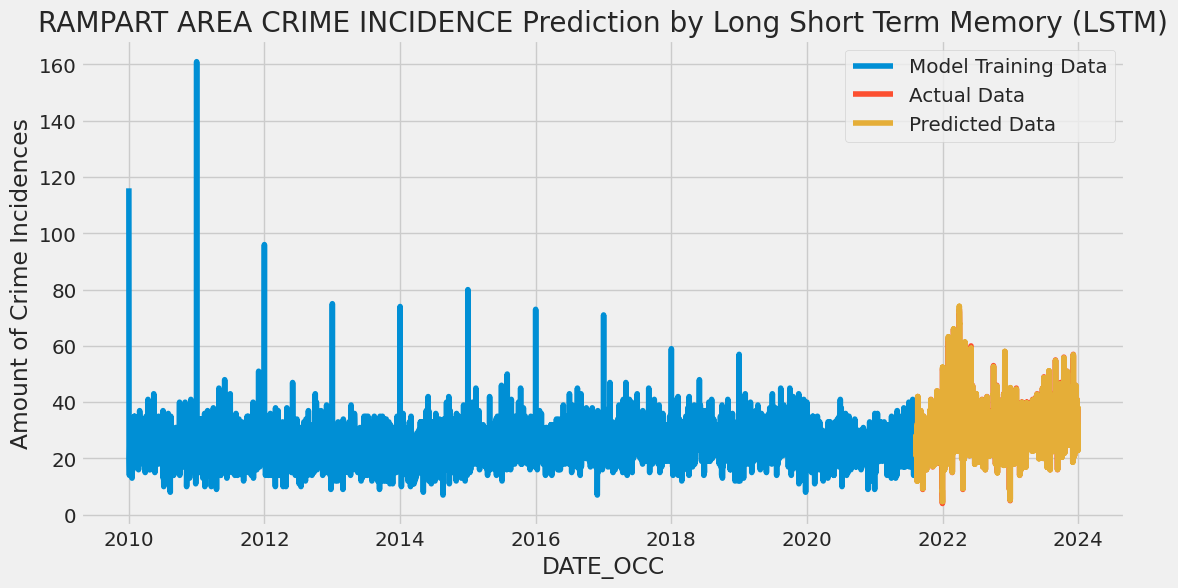

In [70]:
lstm_prediction(Rampart_dataset)

**13. LSTM for Wilshire Area**

In [71]:
def lstm_prediction(Wilshire_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Wilshire_dataset.shape[0]
    df_new = Wilshire_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------WILSHIRE AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('WILSHIRE AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------WILSHIRE AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (103452, 1)
Shape of Validation Set (25862, 1)
Epoch 1/25
2586/2586 - 23s - loss: 4.3560e-04 - val_loss: 1.9400e-04 - 23s/epoch - 9ms/step
Epoch 2/25
2586/2586 - 19s - loss: 2.4411e-04 - val_loss: 2.0895e-04 - 19s/epoch - 7ms/step
Epoch 3/25
2586/2586 - 18s - loss: 2.3759e-04 - val_loss: 1.7243e-04 - 18s/epoch - 7ms/step
Epoch 4/25
2586/2586 - 18s - loss: 2.3355e-04 - val_loss: 1.7507e-04 - 18s/epoch - 7ms/step
Epoch 5/25
2586/2586 - 19s - loss: 2.3113e-04 - val_loss: 1.6410e-04 - 19s/epoch - 7ms/step
Epoch 6/25
2586/2586 - 19s - loss: 2.2845e-04 - val_loss: 3.6508e-04 - 19s/epoch - 7ms/step
Epoch 7/25
2586/2586 - 18s - loss: 2.2893e-04 - val_loss: 1.6818e-04 - 18s/epoch 

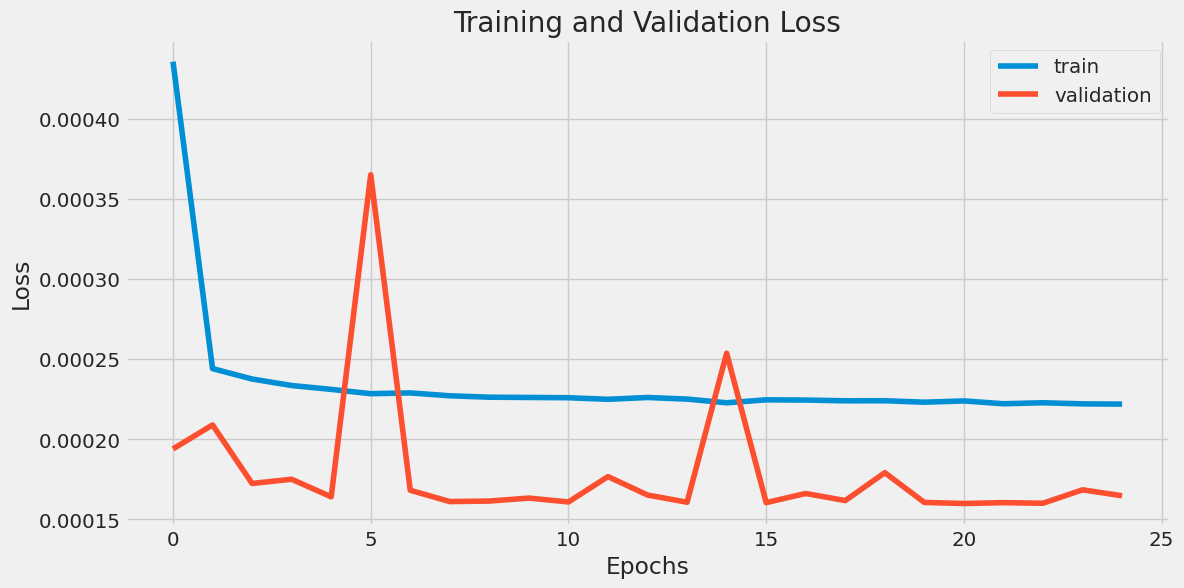

809/809 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.449648
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


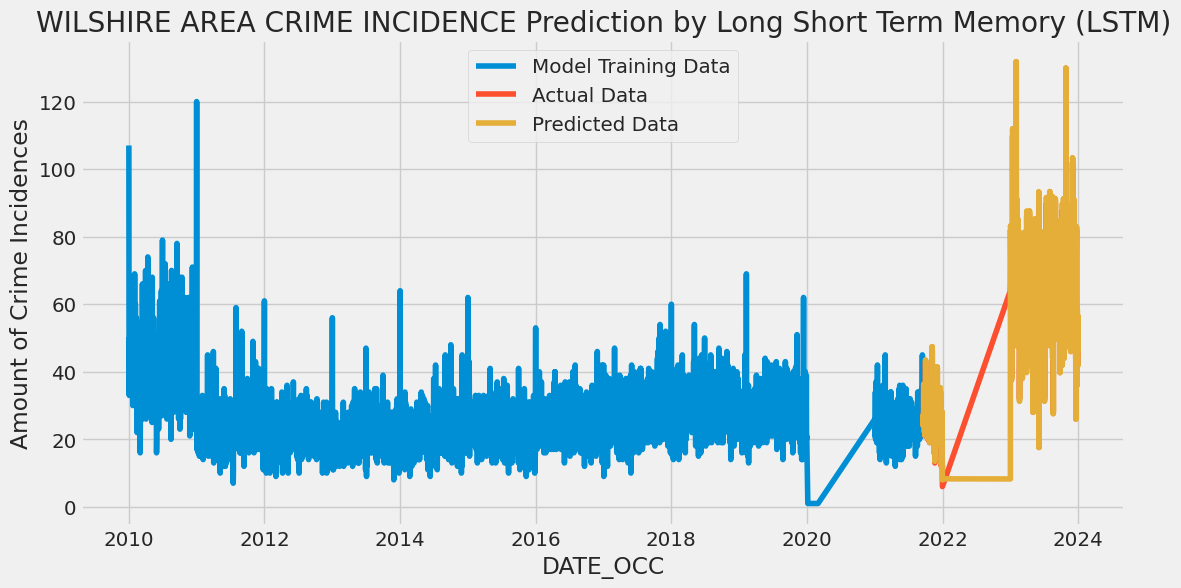

In [72]:
lstm_prediction(Wilshire_dataset)

**14. LSTM for West L.A. Area**

In [73]:
def lstm_prediction(West_LA_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = West_LA_dataset.shape[0]
    df_new = West_LA_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------WEST L.A. AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('WEST L.A. AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------WEST L.A. AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (101954, 1)
Shape of Validation Set (25488, 1)
Epoch 1/25
2548/2548 - 21s - loss: 5.1941e-04 - val_loss: 2.7186e-04 - 21s/epoch - 8ms/step
Epoch 2/25
2548/2548 - 17s - loss: 3.4083e-04 - val_loss: 2.3845e-04 - 17s/epoch - 7ms/step
Epoch 3/25
2548/2548 - 18s - loss: 3.3357e-04 - val_loss: 2.3708e-04 - 18s/epoch - 7ms/step
Epoch 4/25
2548/2548 - 17s - loss: 3.2826e-04 - val_loss: 2.3859e-04 - 17s/epoch - 7ms/step
Epoch 5/25
2548/2548 - 18s - loss: 3.2536e-04 - val_loss: 2.3828e-04 - 18s/epoch - 7ms/step
Epoch 6/25
2548/2548 - 18s - loss: 3.2409e-04 - val_loss: 2.3927e-04 - 18s/epoch - 7ms/step
Epoch 7/25
2548/2548 - 18s - loss: 3.2382e-04 - val_loss: 2.5097e-04 - 18s/epoch

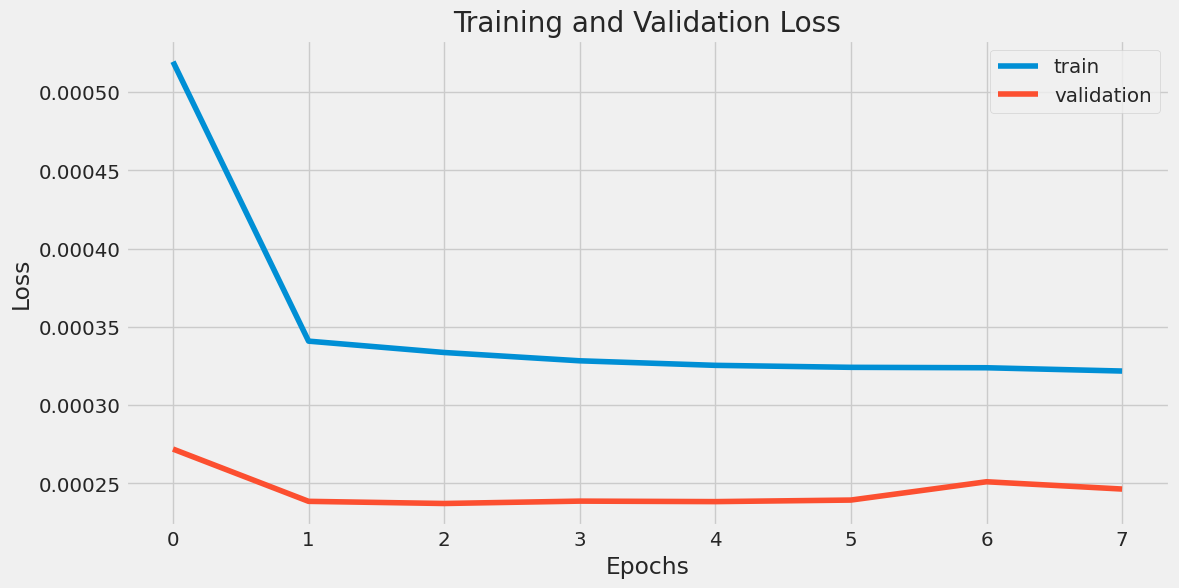

797/797 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.319091
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


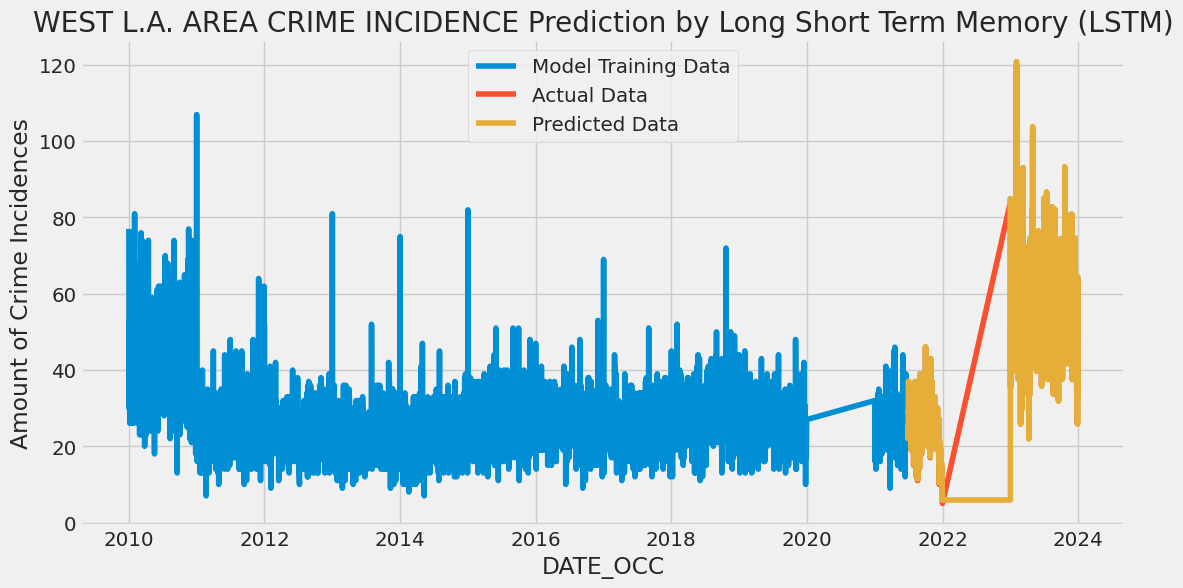

In [74]:
lstm_prediction(West_LA_dataset)

**15. LSTM for West Valley Area**

In [75]:
def lstm_prediction(West_Valley_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = West_Valley_dataset.shape[0]
    df_new = West_Valley_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------WEST VALLEY AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('WEST VALLEY AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------WEST VALLEY AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (101386, 1)
Shape of Validation Set (25346, 1)
Epoch 1/25
2534/2534 - 21s - loss: 2.8520e-04 - val_loss: 1.1255e-04 - 21s/epoch - 8ms/step
Epoch 2/25
2534/2534 - 18s - loss: 1.8670e-04 - val_loss: 1.6531e-04 - 18s/epoch - 7ms/step
Epoch 3/25
2534/2534 - 18s - loss: 1.8579e-04 - val_loss: 1.6607e-04 - 18s/epoch - 7ms/step
Epoch 4/25
2534/2534 - 17s - loss: 1.8237e-04 - val_loss: 1.1215e-04 - 17s/epoch - 7ms/step
Epoch 5/25
2534/2534 - 17s - loss: 1.8519e-04 - val_loss: 1.2465e-04 - 17s/epoch - 7ms/step
Epoch 6/25
2534/2534 - 18s - loss: 1.8004e-04 - val_loss: 1.1522e-04 - 18s/epoch - 7ms/step
Epoch 7/25
2534/2534 - 18s - loss: 1.7960e-04 - val_loss: 1.1739e-04 - 18s/epo

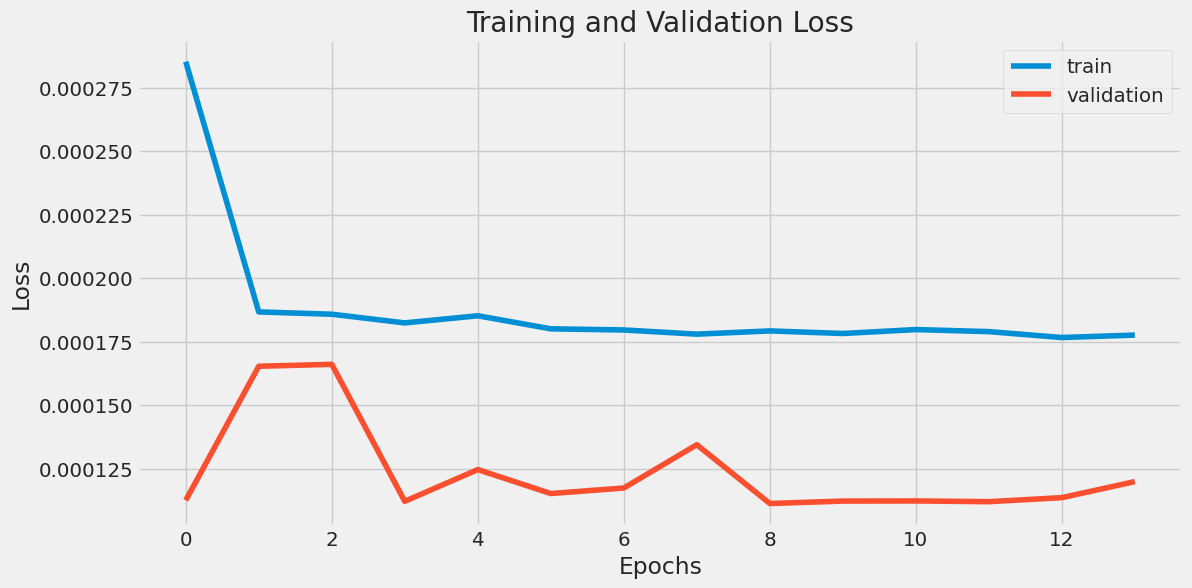

793/793 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.193998
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


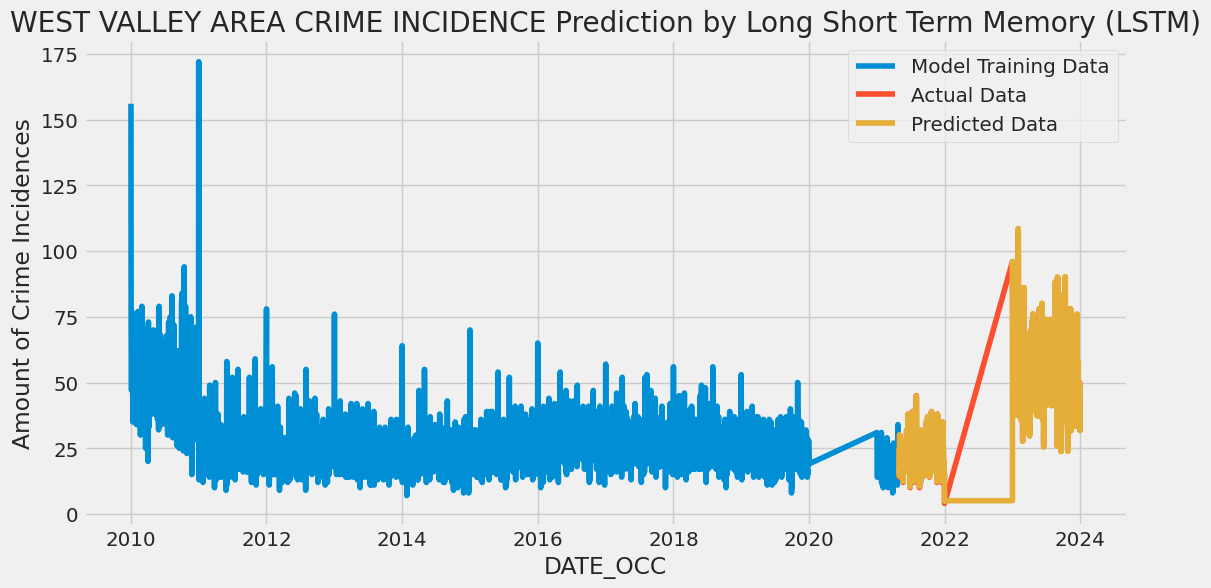

In [76]:
lstm_prediction(West_Valley_dataset)

**16. LSTM for Olympic Area**

In [77]:
def lstm_prediction(Olympic_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Olympic_dataset.shape[0]
    df_new = Olympic_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------OLYMPIC AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('OLYMPIC AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------OLYMPIC AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (101283, 1)
Shape of Validation Set (25320, 1)
Epoch 1/25
2532/2532 - 22s - loss: 2.3577e-04 - val_loss: 8.3765e-05 - 22s/epoch - 9ms/step
Epoch 2/25
2532/2532 - 17s - loss: 1.5062e-04 - val_loss: 1.0413e-04 - 17s/epoch - 7ms/step
Epoch 3/25
2532/2532 - 18s - loss: 1.4712e-04 - val_loss: 1.0376e-04 - 18s/epoch - 7ms/step
Epoch 4/25
2532/2532 - 18s - loss: 1.3794e-04 - val_loss: 7.8083e-05 - 18s/epoch - 7ms/step
Epoch 5/25
2532/2532 - 18s - loss: 1.3718e-04 - val_loss: 8.3436e-05 - 18s/epoch - 7ms/step
Epoch 6/25
2532/2532 - 18s - loss: 1.3470e-04 - val_loss: 8.1547e-05 - 18s/epoch - 7ms/step
Epoch 7/25
2532/2532 - 18s - loss: 1.3660e-04 - val_loss: 8.1393e-05 - 18s/epoch -

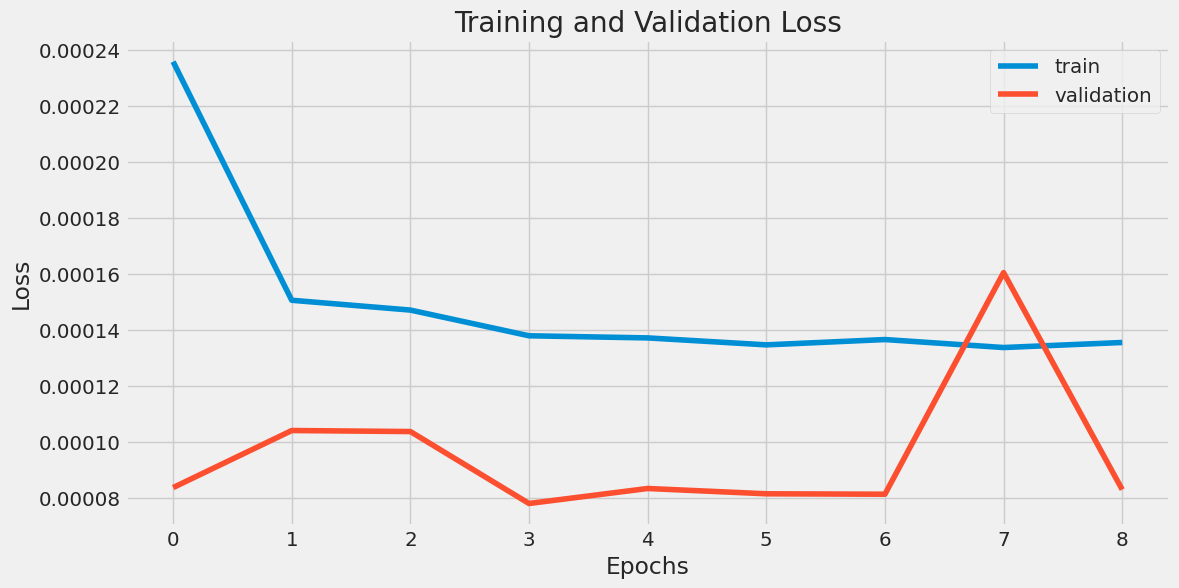

792/792 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.644965
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


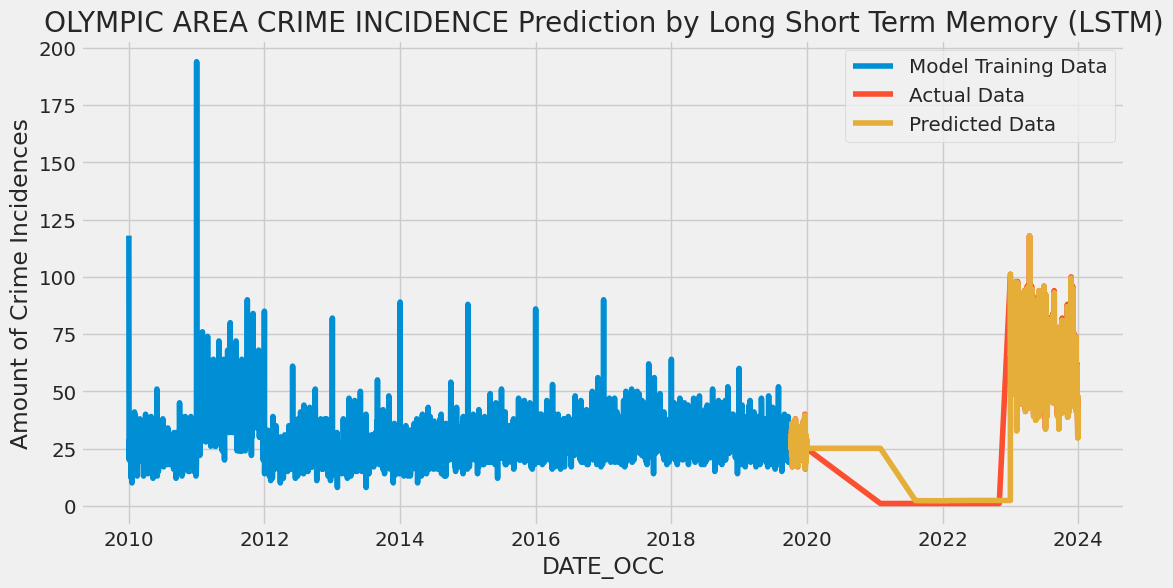

In [78]:
lstm_prediction(Olympic_dataset)

**17. LSTM for Topanga Area**

In [79]:
def lstm_prediction(Topanga_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Topanga_dataset.shape[0]
    df_new = Topanga_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------TOPANGA AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('TOPANGA AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------TOPANGA AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (100684, 1)
Shape of Validation Set (25170, 1)
Epoch 1/25
2517/2517 - 22s - loss: 2.9959e-04 - val_loss: 9.5330e-05 - 22s/epoch - 9ms/step
Epoch 2/25
2517/2517 - 18s - loss: 1.7903e-04 - val_loss: 8.9084e-05 - 18s/epoch - 7ms/step
Epoch 3/25
2517/2517 - 18s - loss: 1.7494e-04 - val_loss: 1.0507e-04 - 18s/epoch - 7ms/step
Epoch 4/25
2517/2517 - 18s - loss: 1.7039e-04 - val_loss: 8.8739e-05 - 18s/epoch - 7ms/step
Epoch 5/25
2517/2517 - 18s - loss: 1.6879e-04 - val_loss: 9.6536e-05 - 18s/epoch - 7ms/step
Epoch 6/25
2517/2517 - 18s - loss: 1.6720e-04 - val_loss: 8.7395e-05 - 18s/epoch - 7ms/step
Epoch 7/25
2517/2517 - 18s - loss: 1.6437e-04 - val_loss: 8.9914e-05 - 18s/epoch -

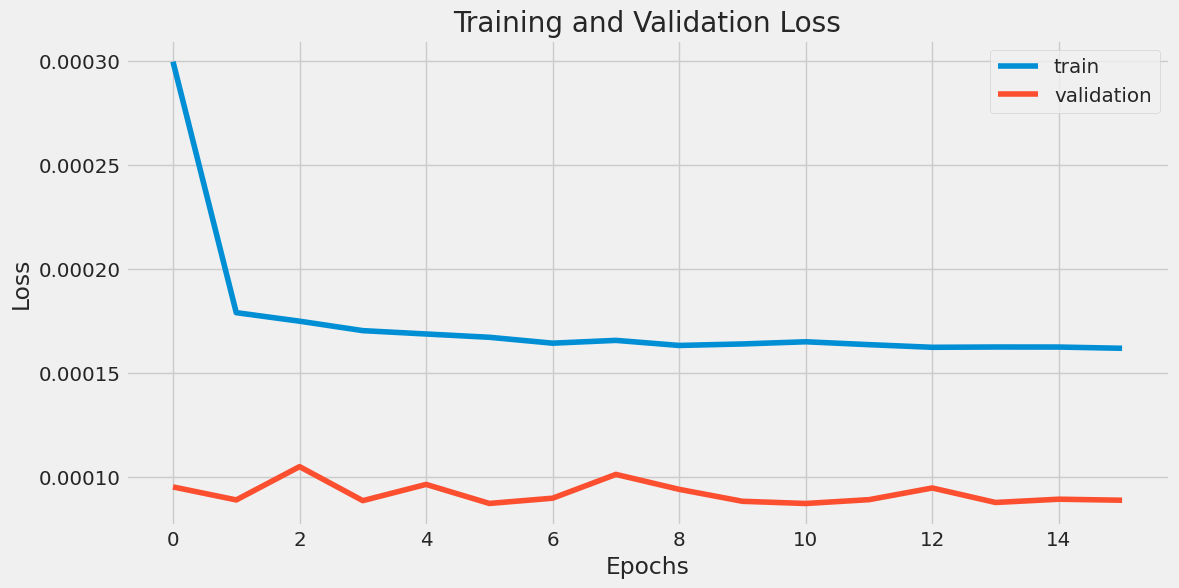

787/787 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.205658
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


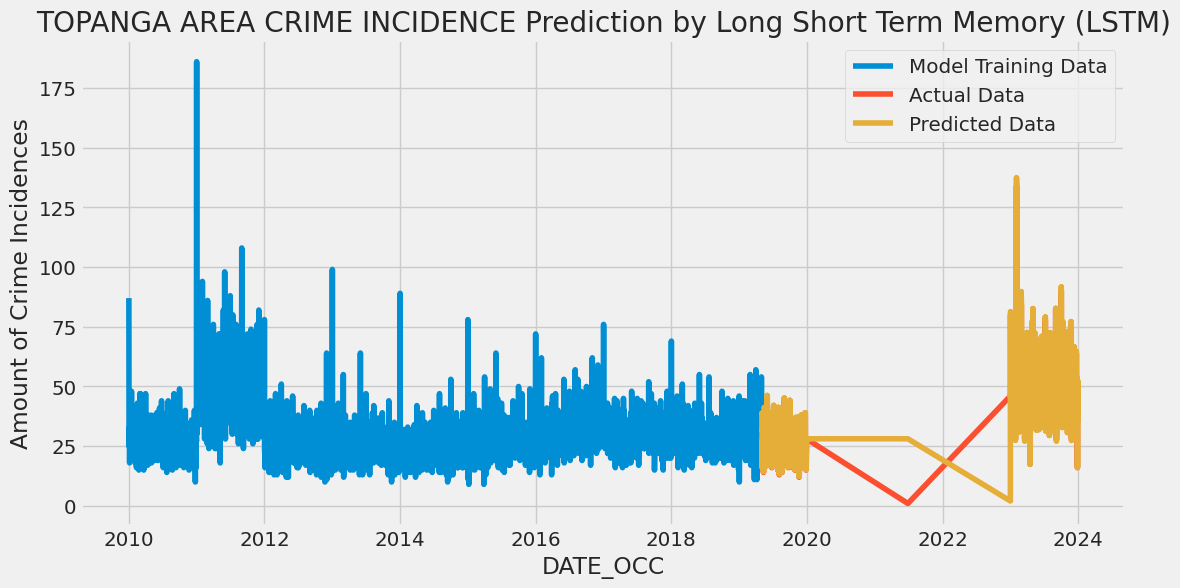

In [80]:
lstm_prediction(Topanga_dataset)

**18. LSTM for Devonshire Area**

In [81]:
def lstm_prediction(Devonshire_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Devonshire_dataset.shape[0]
    df_new = Devonshire_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]

    print('--------------------------------------------------------------------------------------------------')
    print('-----------DEVONSHIRE AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('DEVONSHIRE AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------DEVONSHIRE AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (100336, 1)
Shape of Validation Set (25084, 1)
Epoch 1/25
2508/2508 - 22s - loss: 2.5617e-04 - val_loss: 8.5465e-05 - 22s/epoch - 9ms/step
Epoch 2/25
2508/2508 - 18s - loss: 1.4374e-04 - val_loss: 7.8193e-05 - 18s/epoch - 7ms/step
Epoch 3/25
2508/2508 - 18s - loss: 1.3999e-04 - val_loss: 6.9833e-05 - 18s/epoch - 7ms/step
Epoch 4/25
2508/2508 - 18s - loss: 1.3454e-04 - val_loss: 7.1556e-05 - 18s/epoch - 7ms/step
Epoch 5/25
2508/2508 - 18s - loss: 1.3385e-04 - val_loss: 7.1396e-05 - 18s/epoch - 7ms/step
Epoch 6/25
2508/2508 - 18s - loss: 1.3290e-04 - val_loss: 7.9338e-05 - 18s/epoch - 7ms/step
Epoch 7/25
2508/2508 - 18s - loss: 1.3181e-04 - val_loss: 7.0021e-05 - 18s/epoc

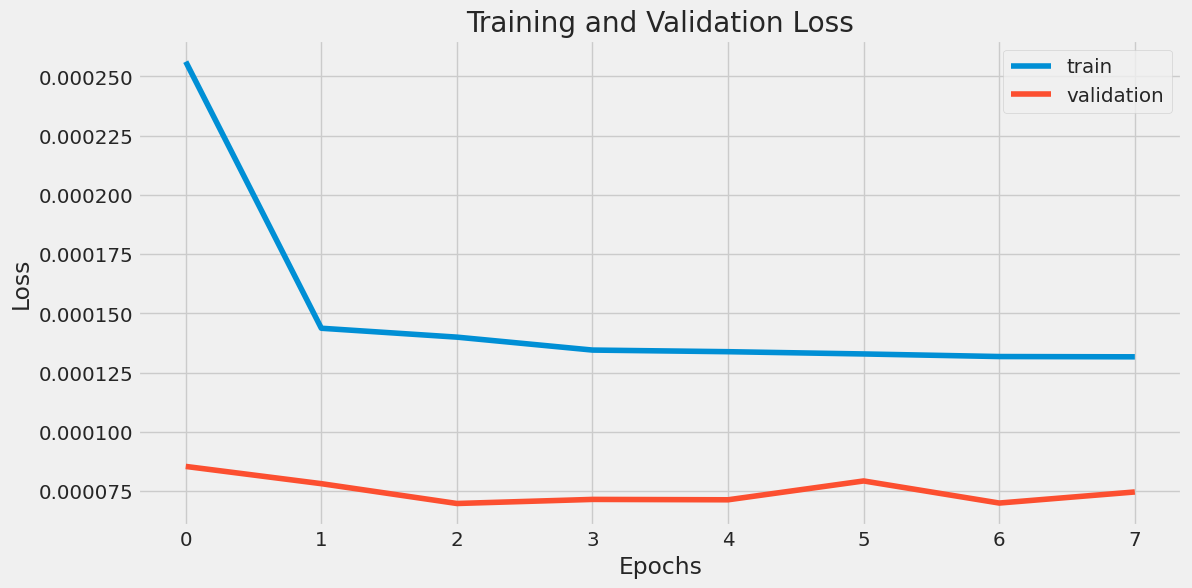

784/784 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.182857
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


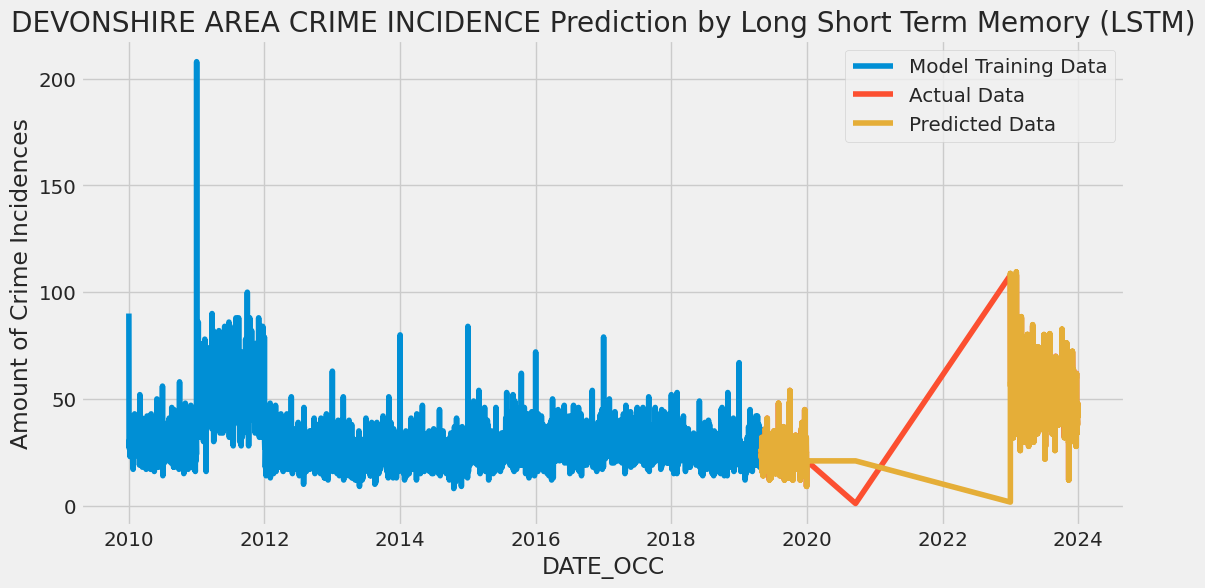

In [82]:
lstm_prediction(Devonshire_dataset)

**19. LSTM for Harbor Area**

In [85]:
def lstm_prediction(Harbor_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Harbor_dataset.shape[0]
    df_new = Harbor_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------HARBOR AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('HARBOR AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------HARBOR AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (99912, 1)
Shape of Validation Set (24978, 1)
Epoch 1/25
2497/2497 - 22s - loss: 2.3935e-04 - val_loss: 8.1272e-05 - 22s/epoch - 9ms/step
Epoch 2/25
2497/2497 - 18s - loss: 1.3210e-04 - val_loss: 7.7014e-05 - 18s/epoch - 7ms/step
Epoch 3/25
2497/2497 - 18s - loss: 1.2525e-04 - val_loss: 7.7755e-05 - 18s/epoch - 7ms/step
Epoch 4/25
2497/2497 - 17s - loss: 1.3130e-04 - val_loss: 7.9877e-05 - 17s/epoch - 7ms/step
Epoch 5/25
2497/2497 - 17s - loss: 1.2462e-04 - val_loss: 8.9932e-05 - 17s/epoch - 7ms/step
Epoch 6/25
2497/2497 - 17s - loss: 1.2508e-04 - val_loss: 8.9462e-05 - 17s/epoch - 7ms/step
Epoch 7/25
2497/2497 - 18s - loss: 1.2382e-04 - val_loss: 1.0120e-04 - 18s/epoch - 7

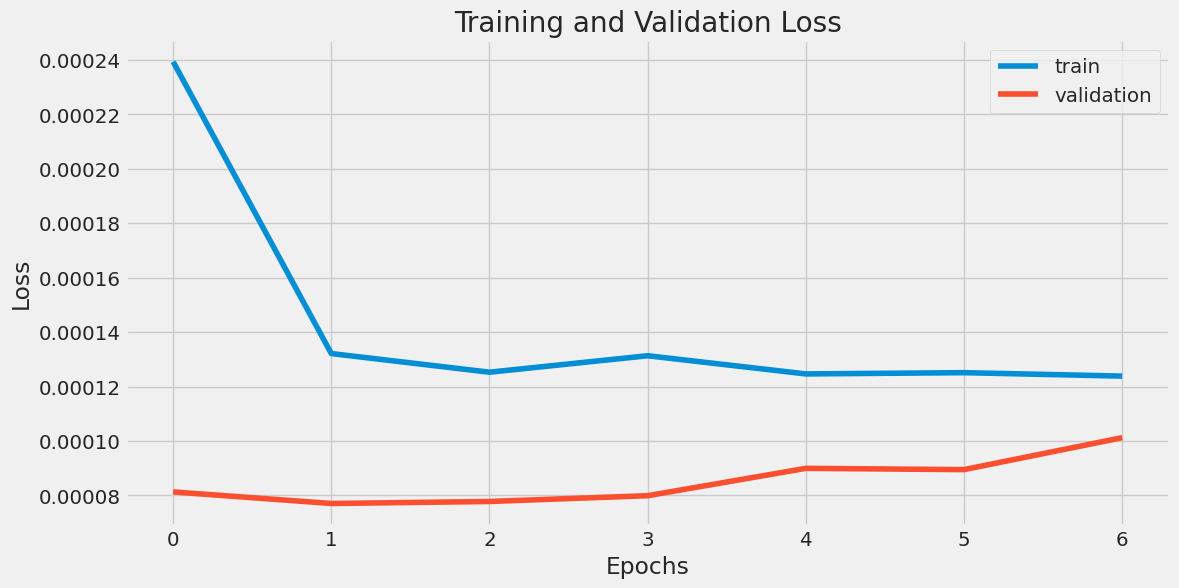

781/781 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    1.736042
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


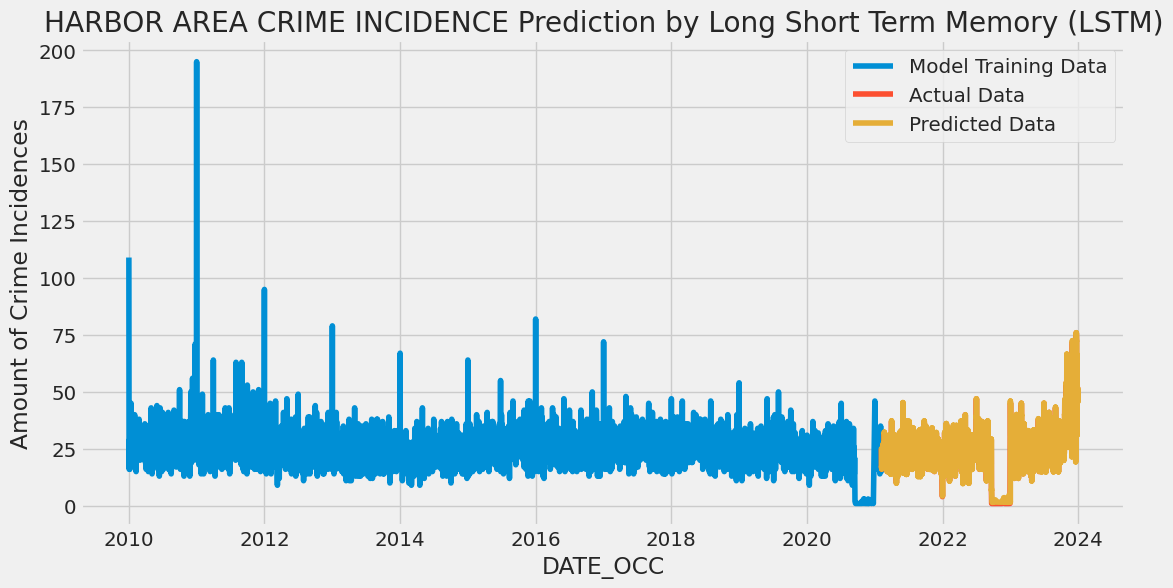

In [86]:
lstm_prediction(Harbor_dataset)

**20. LSTM for Hollenbeck Area**

In [87]:
def lstm_prediction(Hollenbeck_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Hollenbeck_dataset.shape[0]
    df_new = Hollenbeck_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]


    print('--------------------------------------------------------------------------------------------------')
    print('-----------HOLLENBECK AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('HOLLENBECK AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------HOLLENBECK AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (88256, 1)
Shape of Validation Set (22063, 1)
Epoch 1/25
2206/2206 - 19s - loss: 4.1874e-04 - val_loss: 1.8400e-04 - 19s/epoch - 9ms/step
Epoch 2/25
2206/2206 - 15s - loss: 2.6711e-04 - val_loss: 2.5666e-04 - 15s/epoch - 7ms/step
Epoch 3/25
2206/2206 - 16s - loss: 2.7041e-04 - val_loss: 1.7647e-04 - 16s/epoch - 7ms/step
Epoch 4/25
2206/2206 - 16s - loss: 2.5914e-04 - val_loss: 1.8168e-04 - 16s/epoch - 7ms/step
Epoch 5/25
2206/2206 - 15s - loss: 2.5086e-04 - val_loss: 1.8101e-04 - 15s/epoch - 7ms/step
Epoch 6/25
2206/2206 - 16s - loss: 2.5468e-04 - val_loss: 2.1312e-04 - 16s/epoch - 7ms/step
Epoch 7/25
2206/2206 - 16s - loss: 2.4898e-04 - val_loss: 1.7587e-04 - 16s/epoch

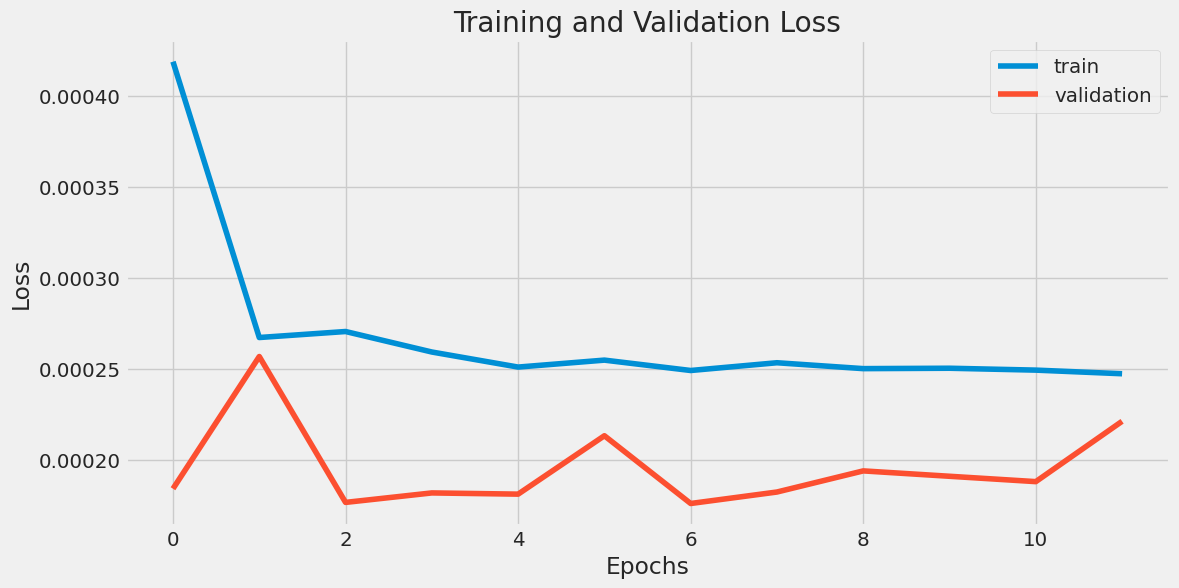

690/690 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    1.685372
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


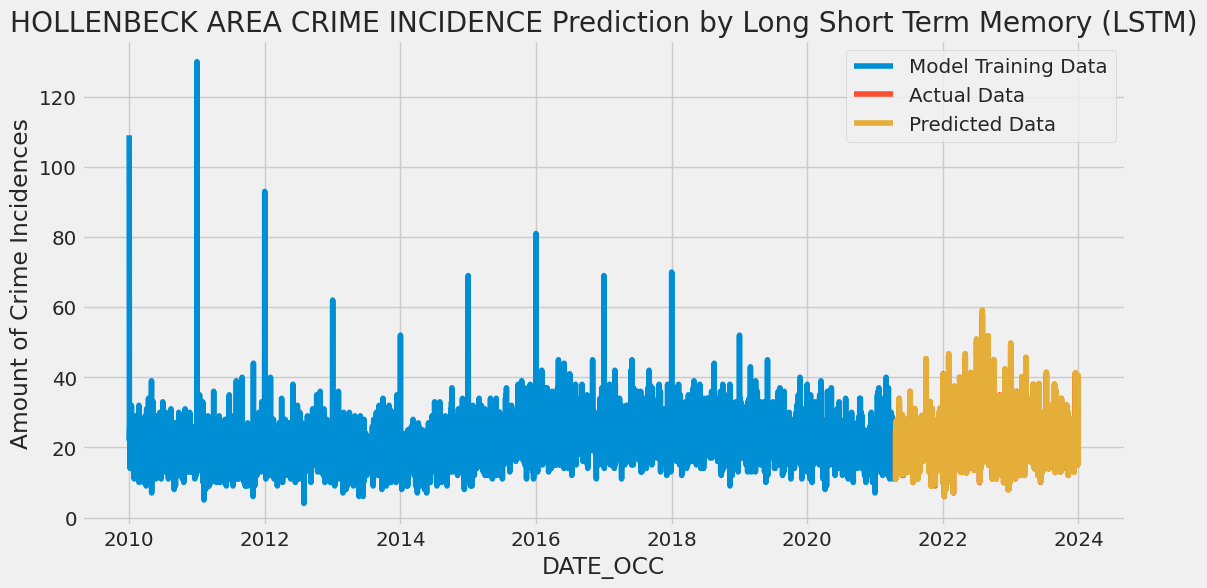

In [88]:
lstm_prediction(Hollenbeck_dataset)

**21. LSTM for Foothill Area**

In [89]:
def lstm_prediction(Foothill_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Foothill_dataset.shape[0]
    df_new = Foothill_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values.reshape(-1,1)
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]

    print('--------------------------------------------------------------------------------------------------')
    print('-----------FOOTHILL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_new.iloc[:ceil(shape * 0.80)].reset_index()['DATE_OCC'].map(dt.datetime.toordinal))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(df_new.iloc[ceil(shape * 0.80):].reset_index()['DATE_OCC'].map(dt.datetime.toordinal)) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape

    plt.figure(figsize=(12, 6))
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('FOOTHILL AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------FOOTHILL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (82151, 1)
Shape of Validation Set (20537, 1)
Epoch 1/25
2053/2053 - 20s - loss: 1.8712e-04 - val_loss: 3.2617e-05 - 20s/epoch - 10ms/step
Epoch 2/25
2053/2053 - 15s - loss: 1.1952e-04 - val_loss: 3.6667e-05 - 15s/epoch - 7ms/step
Epoch 3/25
2053/2053 - 15s - loss: 9.9229e-05 - val_loss: 3.2789e-05 - 15s/epoch - 7ms/step
Epoch 4/25
2053/2053 - 14s - loss: 1.0078e-04 - val_loss: 3.3204e-05 - 14s/epoch - 7ms/step
Epoch 5/25
2053/2053 - 14s - loss: 1.0669e-04 - val_loss: 3.3414e-05 - 14s/epoch - 7ms/step
Epoch 6/25
2053/2053 - 14s - loss: 1.0595e-04 - val_loss: 3.4128e-05 - 14s/epoch - 7ms/step


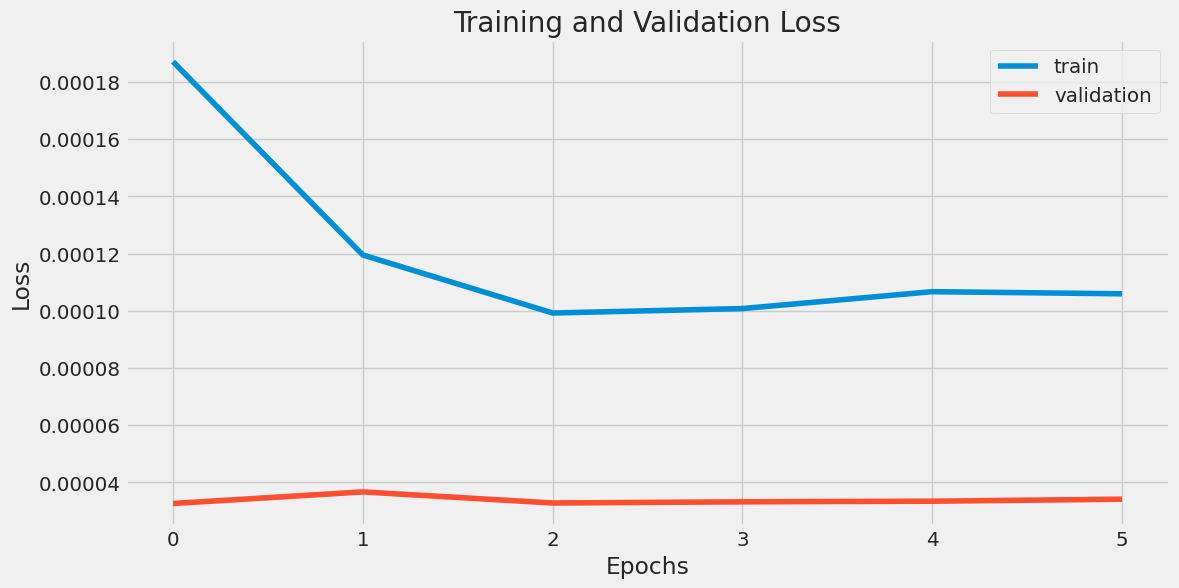

642/642 [==============================] - 3s 3ms/step
RMSE value on validation set: Crime_Incidence    2.229846
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


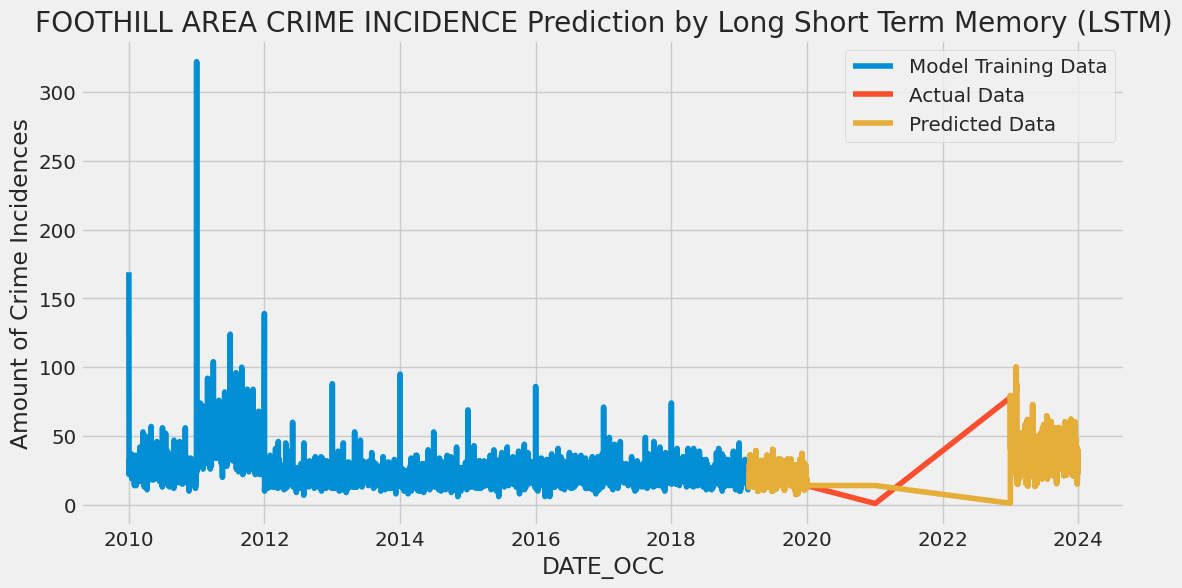

In [90]:
lstm_prediction(Foothill_dataset)